In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path
import pickle

home = str(Path.home())
data_path = os.path.join(home, "GA_generation", "Data", "trajs_dict_ga_14_cleaned.pkl")

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd

from airtraj import trajectories as traj
from traffic.data import airports
from traffic.drawing import countries
import traffic.core.geodesy as geo

with open(data_path, "rb") as handle:
    trajs_dict = pickle.load(handle)

GA = traj.generate_Traffic_from_trajs_dict(trajs_dict).assign_id().eval(desc="")
# Putting timestamps in the same fromat as traffic object
GA.data.timestamp = pd.to_datetime(GA.data.timestamp).dt.tz_localize("UTC")

<ipython-input-2-2b4120a4bd27>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
100%|██████████| 646/646 [00:02<00:00, 292.95it/s]


  0%|          | 0/646 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

Preprocessing à faire : 
- Normaliser le début des trajectoires (par exemple, le premier point du premier aligned on ils)
- Séparer les plusieurs go-arounds s'il y en a 
- Enlever les holding patterns
- Enlever les go-arounds vers une autre piste
- Ne sélectionner les go-arounds que d'un seul et même côté
- Un go around = de la fin de la piste jusqu'à l'ils (on ne s'occupe pas des early ga) 
- Trouver un moyen de resample pour avoir le même nombre de points : Comme les go-arounds sont tous des tailles et durées différentes, on va peut être devoir dropper la composante temporelle

# Selecting the right GA

In [3]:
# More than 1 ga
def count_GA(f):
    nb_ils = len(f.aligned_on_ils(airports["LSZH"]))
    if nb_ils > 2:
        return f
    else:
        return None


GAs = GA.iterate_lazy().pipe(count_GA).eval(desc="")

  0%|          | 0/646 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

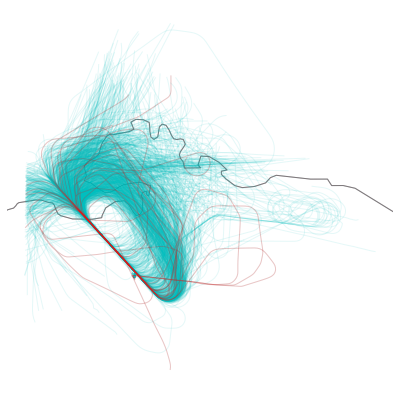

<IPython.core.display.Javascript object>

In [4]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA.plot(ax, alpha=0.1, color="c")
    GAs.plot(ax, alpha=0.2, color="r")

In [5]:
dict_ils = {}
for f in tqdm(GA):
    ils = f.aligned_on_ils("LSZH")
    starts = []
    for seg in ils:
        if seg.max("ILS") == "14":
            starts.append(
                seg.stop
            )  # We take a go around from runway threshold to runway threshold
    dict_ils[f.flight_id] = starts

  0%|          | 0/646 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [6]:
from collections import Counter

Counter(list(map(len, dict_ils.values())))

Counter({2: 631, 0: 2, 1: 8, 3: 5})

<IPython.core.display.Javascript object>

In [7]:
# Extracting Go around for flights with only one go around runway 14
def first_ga(f):
    if f.flight_id in dict_ils.keys():
        if len(dict_ils[f.flight_id]) == 2:
            return f.between(dict_ils[f.flight_id][0], dict_ils[f.flight_id][1])
        else:
            return None
    else:
        return None


GA1 = GA.iterate_lazy().pipe(first_ga).resample("1s").eval(desc="", max_workers=10)

  0%|          | 0/646 [00:00<?, ?it/s]

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

<IPython.core.display.Javascript object>

In [8]:
# Récupération des coordonnées du seuil de piste 14
a = airports["LSZH"].runways.data[airports["LSZH"].runways.data.name == "14"]
latlonbear14 = np.round(
    [a.latitude.values[0], a.longitude.values[0], a.bearing.values[0]], 3
)
latlonbear14

# Créatoin du seuil
set0 = geo.destination(latlonbear14[0], latlonbear14[1], latlonbear14[2], 3300)
set1 = geo.destination(set0[0], set0[1], set0[2] + 90, 500)  # point A du seuil
set2 = geo.destination(set0[0], set0[1], set0[2] - 90, 500)  # point B du seuil
set3 = geo.destination(set2[0], set2[1], latlonbear14[2], 600)  # Epaisseur
set4 = geo.destination(set1[0], set1[1], latlonbear14[2], 600)  # Epaisseur

# Forme en bout de piste 14
from shapely.geometry import Polygon

lat_point_list = [set1[0], set2[0], set3[0], set4[0]]
lon_point_list = [set1[1], set2[1], set3[1], set4[1]]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))

notinend = []
inend = []
clipnotin = []
clipin = []
for f in tqdm(GA1):
    if not f.intersects(polygon_geom):
        notinend.append(f.flight_id)
    else:
        inend.append(f.flight_id)

for f in tqdm(GA1):
    if f.clip(polygon_geom) is None:
        clipnotin.append(f.flight_id)
    else:
        clipin.append(f.flight_id)

  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/631 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [9]:
# Quels sont les vols qui ont un intersect = True, mais un clip = False
inter = list(set(clipnotin) & set(inend))
len(inter)

from ipyleaflet import Polygon as Popo

m = GA1[inter].map_leaflet(zoom=12)

coords = list((lat, lon) for (lon, lat, *_) in polygon_geom.exterior.coords)
shape = Popo(locations=coords, color="red")
m.add_layer(shape)

m

Map(center=[47.57341960673328, 8.495755260552817], controls=(ZoomControl(options=['position', 'zoom_in_text', …

<IPython.core.display.Javascript object>

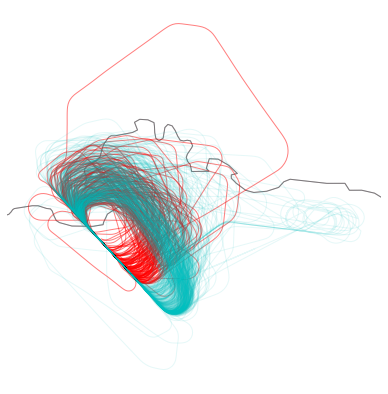

<IPython.core.display.Javascript object>

In [10]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1[notinend].plot(ax, alpha=0.5, color="r")
    GA1[inend].plot(ax, alpha=0.1, color="c")

In [30]:
def from_end_runway(flight):
    g = flight.clip(polygon_geom)
    if g is None:
        return None
    return flight.after(g.start)


GA1_norm = GA1.iterate_lazy().pipe(from_end_runway).eval(desc="")
GA1_norm

  0%|          | 0/631 [00:00<?, ?it/s]

count
flight_id         
FLJ602_415    2990
CAZ802_409    2186
SWR963_410    2097
SWR109R_637   1699
SIA346_632    1552
EZY42PU_332   1507
BAW14R_358    1378
UAE2MJ_348    1370
VLG21QR_166   1289
EZY84MN_412   1279

<IPython.core.display.Javascript object>

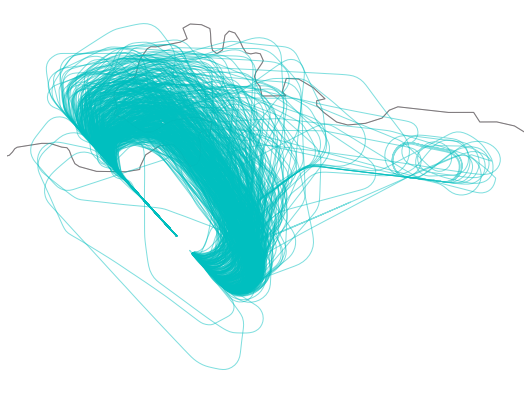

<IPython.core.display.Javascript object>

In [13]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1_norm.plot(ax, alpha=0.5, color="c")

In [31]:
from traffic.data import navaids


def til_FAF(flight):
    g = flight.query("distance < (1.5*1.850)")
    if g is None:
        return None
    return flight.before(g.stop)


GA1_norm = GA1_norm.distance(navaids["OSNEM"]).pipe(til_FAF).eval(desc="")
GA1_norm

  0%|          | 0/486 [00:00<?, ?it/s]

count
flight_id         
FLJ602_415    2868
CAZ802_409    2058
SWR963_410    1971
SWR109R_637   1583
SIA346_632    1418
EZY42PU_332   1371
BAW14R_358    1251
UAE2MJ_348    1247
VLG21QR_166   1173
EZY84MN_412   1161

<IPython.core.display.Javascript object>

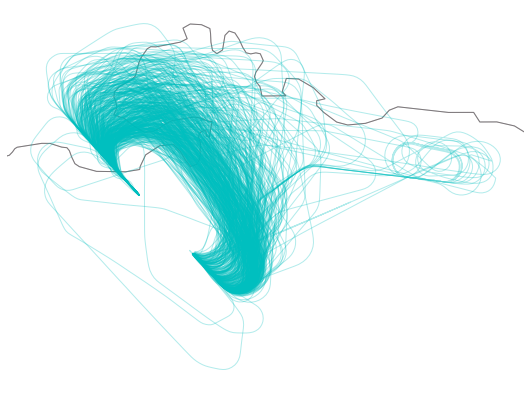

<IPython.core.display.Javascript object>

In [15]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1_norm.plot(ax, alpha=0.3, color="c")

In [32]:
def crop_holdings(flight):
    g = flight.query("distance < 2")
    if g is None:
        return flight
    else:
        return None


GA1_norm = GA1_norm.distance(navaids["AMIKI"]).pipe(crop_holdings).eval(desc="")
GA1_norm

  0%|          | 0/486 [00:00<?, ?it/s]

count
flight_id         
BAW14R_358    1251
SWR771_431    1099
UAL134_054    1069
None_322      1065
SWR68L_480    1063
SWR89T_309    1033
HBKPN_611     1027
SWR1069_237   1021
IBE3464_456    987
EWG9MT_148     985

<IPython.core.display.Javascript object>

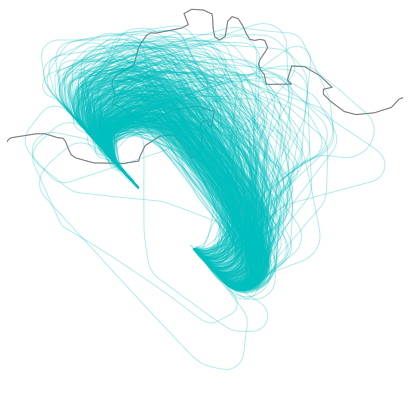

<IPython.core.display.Javascript object>

In [17]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1_norm.plot(ax, alpha=0.3, color="c")

In [18]:
GA1_norm.map_leaflet()

Map(center=[47.57466185905321, 8.540876334453626], controls=(ZoomControl(options=['position', 'zoom_in_text', …

<IPython.core.display.Javascript object>

In [33]:
# drop GA on wrong side
GA1_norm = GA1_norm.query(
    "flight_id not in ['SWR74A_164', 'OMA153_038', 'AUI471_234', 'SWR202A_173', 'SWR1069_237']"
)

<IPython.core.display.Javascript object>

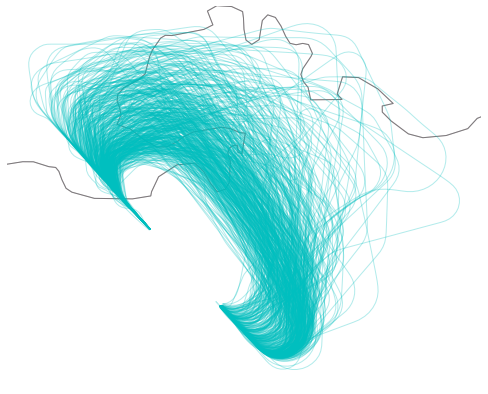

<IPython.core.display.Javascript object>

In [34]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1_norm.plot(ax, alpha=0.3, color="c")

In [35]:
long = [
    flight.flight_id for flight in GA1_norm if (flight.duration.total_seconds() > 800)
]
print(len(long))

GA1_norm = GA1_norm.query("flight_id not in {}".format(long))
# GA1_norm[long].map_leaflet(zoom=9)

59


<IPython.core.display.Javascript object>

In [36]:
GA1_norm

count
flight_id         
SWR287A_167    795
SWR1327_617    794
SWR39_335      794
UAE2MJ_136     789
VLG73DB_453    789
SWR2561_562    785
SWR184H_465    783
SIA346_053     782
AFR19RF_552    781
SWR819_128     781

<IPython.core.display.Javascript object>

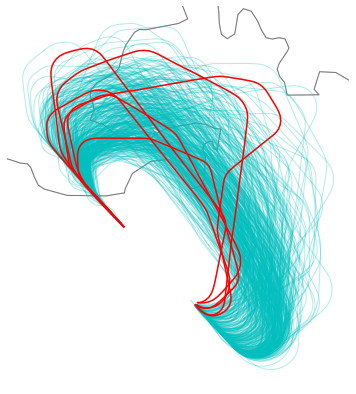

<IPython.core.display.Javascript object>

In [37]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    GA1_norm.plot(ax, alpha=0.3, color="c")
    GA1_norm[295].plot(ax, alpha=1, color="r")
    GA1_norm[0].plot(ax, alpha=1, color="r")
    GA1_norm[350].plot(ax, alpha=1, color="r")
    GA1_norm[214].plot(ax, alpha=1, color="r")
    GA1_norm[202].plot(ax, alpha=1, color="r")
    GA1_norm[382].plot(ax, alpha=1, color="r")

In [38]:
# drop flight that mess up the resampling
GA1_norm = GA1_norm.query(
    "flight_id not in {}".format(
        [
            GA1_norm[0].flight_id,
            GA1_norm[350].flight_id,
            GA1_norm[295].flight_id,
            GA1_norm[214].flight_id,
            GA1_norm[202].flight_id,
            GA1_norm[382].flight_id,
        ]
    )
)

<IPython.core.display.Javascript object>

In [72]:
GA1_norm.to_parquet("Data/Go_Arounds_clean.parquet")

<IPython.core.display.Javascript object>

# Data Preprocessing : finding the median trajectory

Pour trouver la trajectoire médiane, on resample à une granularité faible. Une fois cette trajectoire trouvée, on la resample au nombre de points désiré afin de resampler toute la base.  

Le fait d'avoir un trajectoire exterieur pour référence va faire en sorte d'avoir des trajectoires resampled plus smooth, mais au risque d'y avoir des points mal placés, alors qu'une trajectoire intérieure va nous donner des trajectoires resamplé moins smooth, mais avec moins de points mal placés

In [39]:
# plus court
durations = []
for f in GA1_norm:
    durations.append(f.duration)

shorter = np.argmin(durations)
longer = np.argmax(durations)

print("shortest :", shorter)
print("longest :", longer)

shortest : 97
longest : 302


<IPython.core.display.Javascript object>

In [40]:
import pyproj
from traffic.core import Traffic

swiss = pyproj.Proj(init="EPSG:21781")

data = GA1_norm.resample(200).compute_xy(projection=swiss).eval(desc="")

features = ["x", "y"]
raw_data = np.stack(list(f.data[features].values.ravel() for f in data))

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


  0%|          | 0/407 [00:00<?, ?it/s]

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

<IPython.core.display.Javascript object>

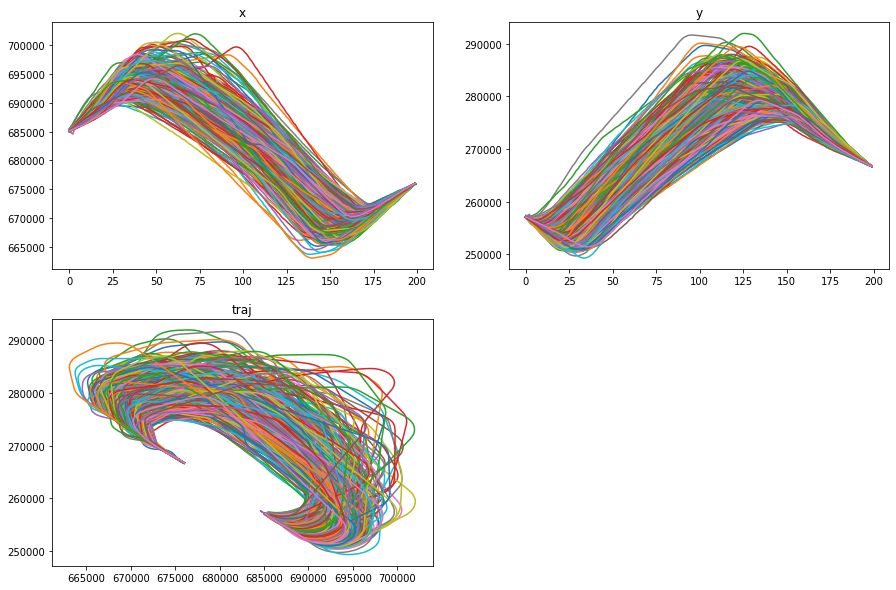

<IPython.core.display.Javascript object>

In [41]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(raw_data[:, ::2].T)
plt.title("x")

plt.subplot(222)
plt.plot(raw_data[:, 1::2].T)
plt.title("y")

plt.subplot(223)
plt.plot(raw_data[:, ::2].T, raw_data[:, 1::2].T)
plt.title("traj")

plt.show()

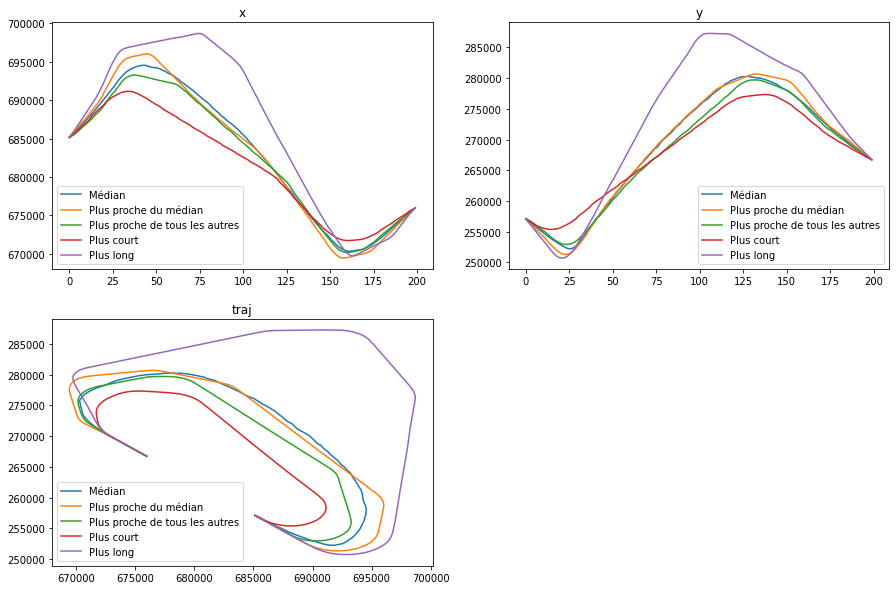

<IPython.core.display.Javascript object>

In [42]:
mean = np.median(raw_data, axis=0)

dist = []
for i in range(raw_data.shape[0]):
    dist.append(np.linalg.norm(np.median(raw_data, axis=0) - raw_data[i, :]))
centroid = np.argmin(dist)

every_dist = np.zeros((raw_data.shape[0], raw_data.shape[0]))
for i in range(raw_data.shape[0]):
    base = raw_data[i, :]
    for j in range(raw_data.shape[0]):
        every_dist[i, j] = np.linalg.norm(base - raw_data[j, :])
closest = np.argmin(np.median(every_dist, axis=0))

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(mean[::2].T)
plt.plot(raw_data[centroid, ::2].T)
plt.plot(raw_data[closest, ::2].T)
plt.plot(raw_data[shorter, ::2].T)
plt.plot(raw_data[longer, ::2].T)
plt.legend(
    [
        "Médian",
        "Plus proche du médian",
        "Plus proche de tous les autres",
        "Plus court",
        "Plus long",
    ]
)
plt.title("x")

plt.subplot(222)
plt.plot(mean[1::2].T)
plt.plot(raw_data[centroid, 1::2].T)
plt.plot(raw_data[closest, 1::2].T)
plt.plot(raw_data[shorter, 1::2].T)
plt.plot(raw_data[longer, 1::2].T)
plt.legend(
    [
        "Médian",
        "Plus proche du médian",
        "Plus proche de tous les autres",
        "Plus court",
        "Plus long",
    ]
)
plt.title("y")

plt.subplot(223)
plt.plot(mean[::2].T, mean[1::2].T)
plt.plot(raw_data[centroid, ::2].T, raw_data[centroid, 1::2].T)
plt.plot(raw_data[closest, ::2].T, raw_data[closest, 1::2].T)
plt.plot(raw_data[shorter, ::2].T, raw_data[shorter, 1::2].T)
plt.plot(raw_data[longer, ::2].T, raw_data[longer, 1::2].T)
plt.legend(
    [
        "Médian",
        "Plus proche du médian",
        "Plus proche de tous les autres",
        "Plus court",
        "Plus long",
    ]
)
plt.title("traj")

plt.show()

In [43]:
print("médian :", closest)
print("Plus court :", shorter)
print("Plus long :", longer)

médian : 330
Plus court : 97
Plus long : 302


<IPython.core.display.Javascript object>

# Resamplig according to the median trajectory

In [44]:
def perp_to_ref(ref_traj_x, ref_traj_y, ref_traj_alt):

    """
    Inputs : 
    ref_traj_x : array of x coordinates of the reference trajectory
    ref_traj_y : array of y coordinates of the reference trajectory
    ref_traj_alt : array of the altitude of the reference trajectory
    
    Outputs : 
    perpendiculars : slope, intersect, and coordinates of the crossing point between perpendicular and ref traj
    """
    perpendiculars = []

    for i in range(len(ref_traj_x)):

        # Calculus of the perpendicular
        slope = (ref_traj_y[i] - ref_traj_y[i - 1]) / (
            ref_traj_x[i] - ref_traj_x[i - 1]
        )  # works too for i = 0
        p_slope = -1.0 / slope
        p_intersect = ref_traj_y[i] - p_slope * ref_traj_x[i]
        perpendiculars.append(
            (p_slope, p_intersect, ref_traj_x[i], ref_traj_y[i], ref_traj_alt[i])
        )

    return perpendiculars

<IPython.core.display.Javascript object>

In [45]:
def distances_to_line1(X0, Y0, m, k):
    dist_horiz = np.abs(k + m * X0 - Y0) / np.sqrt(1 + m ** 2)
    return dist_horiz

def sampling_from_ref1(perpendiculars, to_sample_x, to_sample_y):

    """
    Inputs : 
    perpendiculars : output from perp_to_ref
    to_sample_x : array of x coordinates of the trajectory to sample
    to_sample_y : array of y coordinates of the trajectory to sample
    
    Outputs : 
    argmin : index of sampled points within the traj to sample
    """
    
    argmin = []

    for i in range(len(perpendiculars)):
        
        p_slope = perpendiculars[i][0]
        p_intersect = perpendiculars[i][1]
        ref_traj_x = perpendiculars[i][2]
        ref_traj_y = perpendiculars[i][3]

        if len(argmin) == 0:
            remain_a = to_sample_x
            remain_b = to_sample_y
            offset_argmin = 0
            argmin.append(0)

        else:
            # On fait +1 pour éviter à avoir à répéter plusieur fois le même point
            
            remain_a = to_sample_x[(argmin[-1] + 1) :(argmin[-1] + 1) + 200]
            remain_b = to_sample_y[(argmin[-1] + 1) :(argmin[-1] + 1) + 200]
            offset_argmin = argmin[-1] + 1
        
            #distance to line in 2D
            dists_to_line = distances_to_line1(remain_a, remain_b, p_slope, p_intersect)

            #We take the closest points to perpendicular
            candidates = np.argsort(dists_to_line)[:10]
            print("candidates :", candidates)
            

            #If we have some spurious points in the candidates
            if (candidates.max() - candidates.min()) > 20:
                #we take the point with the min distance to perpendicular among the closest to the ref point
                #in term of advancement in the trajectory
                right_point = candidates[candidates < candidates.mean()][0]
                
            #when we only have spurious points within the selected batch
            #That much because sometimes perpendiculars are crossing the traj before the previously selected point
            #So the algorithm detect the batch of closests points way too far from the ref
            #so we take the next one
            elif candidates.min() > 140 : 
                right_point = 0
            
            else : 
                right_point = candidates[0]

            argmin.append(right_point + offset_argmin)
            print("right point :", right_point)
            print("argmin :", argmin[-1])
            print("")

    return argmin


<IPython.core.display.Javascript object>

Il faut faire attention à plusieurs choses : 
- Si les perpendiculaires suivantes croisent la trajectoires avant les perpendiculaires précédentes, on a des problèmes à cause de "remain" dans l'algorithme. On préfèrera enlever ces cas de figure de l'étude.
- Il faut faire attentions à la condition "candidates.min() > 140". Elle permet de s'assurer que le point sélectionné ne soit pas trop loin du point précédent. Néanmoins, selon le nombre de points samplés, il se peut que la distance entre deux points consécutifs peut être grand. On prendra donc des valeurs relaivement grandes pour un sampling avec peu de points, et faibles pour un sampling avec beaucoup de points. 

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)


230


/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)


candidates : [ 12 171 172  13  11 170  14  10 173 169]
right point : 12
argmin : 13

candidates : [159  11  12 160  13  10 158 161  14   9]
right point : 11
argmin : 25

candidates : [ 13 159 160  12  14 158 161 157  11 162]
right point : 13
argmin : 39

candidates : [168  16 169 167  17 170 166  15 171 165]
right point : 16
argmin : 56

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 75

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 95

candidates : [27 26 28 25 29 24 30 23 31 32]
right point : 27
argmin : 123

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 140

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 154

candidates : [10  9 11  8 12  7 13 14  6 15]
right point : 10
argmin : 165

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 174

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 185

candidates : [ 9  8 10  7 11  6  5 12  4 13]
right poin

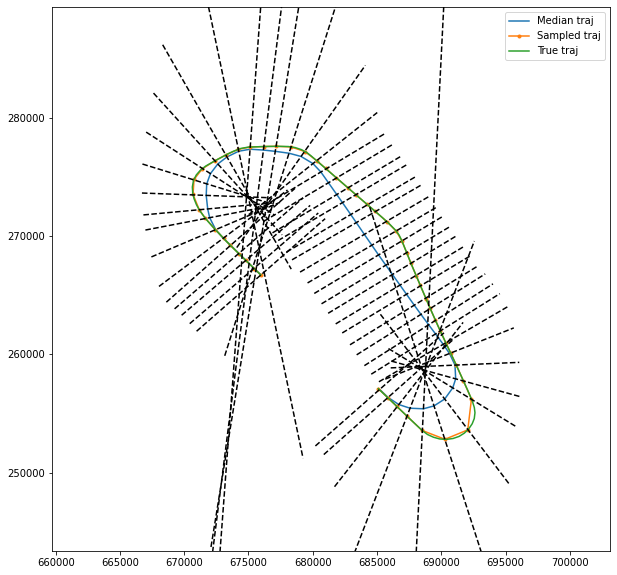

<IPython.core.display.Javascript object>

In [73]:
# take the shrotest traj (97)
nb_points = 50
x_centroid, y_centroid, alt_centroid = (
    data[97].resample(nb_points).data.x.values,
    data[97].resample(nb_points).data.y.values,
    data[97].resample(nb_points).data.altitude.values,
)

sel = np.random.randint(406)
# sel = "EWG5FW_205"
# sel = 213
print(sel)
a = GA1_norm[sel].resample("1s").compute_xy(swiss).data.x.values
b = GA1_norm[sel].resample("1s").compute_xy(swiss).data.y.values
c = GA1_norm[sel].resample("1s").data.altitude.values

perpendiculars = perp_to_ref(x_centroid, y_centroid, alt_centroid)
# argmin = sampling_from_ref(perpendiculars, a, b, c, lbda=0.8)
argmin = sampling_from_ref1(perpendiculars, a, b)


plt.figure(figsize=(10, 10))

plt.plot(x_centroid.T, y_centroid.T)
plt.plot(a[argmin], b[argmin], marker=".")
plt.plot(a, b)
plt.legend(["Median traj", "Sampled traj", "True traj"])

for ele in perpendiculars:
    y1 = ele[0] * (ele[2] - 5000) + ele[1]
    y2 = ele[0] * (ele[2] + 5000) + ele[1]

    plt.plot(
        [(ele[2] - 5000), (ele[2] + 5000)], [y1, y2], color="black", linestyle="--",
    )

plt.xlim(x_centroid.min() - 12000, x_centroid.max() + 12000)
plt.ylim(y_centroid.min() - 12000, y_centroid.max() + 12000)

plt.show()

In [74]:
# resampling accoring to the previous method

nb_points = 50

from traffic.core import Flight

GA1_norm_resampled = (
    GA1_norm.resample("1s").compute_xy(swiss).eval(desc="resampling 1s")
)
x_centroid, y_centroid, alt_centroid = (
    data[97].resample(nb_points).data.x.values,
    data[97].resample(nb_points).data.y.values,
    data[97].resample(nb_points).data.altitude.values,
)

t_GA_resampled_data = []
perpendiculars = perp_to_ref(x_centroid, y_centroid, alt_centroid)
pd.DataFrame(perpendiculars, columns=["m", "p", "x", "y", "z"]).to_parquet(
    "/cluster/home/kruu/GA_generation/Data/Normals_sampling.parquet"
)

for f in tqdm(GA1_norm_resampled):

    a = f.data.x.values
    b = f.data.y.values

    argmin = sampling_from_ref1(perpendiculars, a, b)
    ts_points = f.data.iloc[argmin, :].timestamp

    # Reconstruct flight
    new_f = []
    for el in ts_points:
        new_f.append(f.at(el))
    new_f_df = pd.DataFrame(new_f)
    new_f_df.reset_index(level=0, inplace=True)
    new_f_df = new_f_df.rename(columns={"index": "timestamp"})

    t_GA_resampled_data.append(new_f_df)

t_GA_resampled = Traffic(pd.concat(t_GA_resampled_data))
t_GA_resampled.to_parquet("/cluster/home/kruu/GA_generation/Data/GA_resampled.parquet")

resampling 1s:   0%|          | 0/407 [00:00<?, ?it/s]

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traff

  0%|          | 0/407 [00:00<?, ?it/s]

candidates : [189  12  11 190 188  13  10 191  14 187]
right point : 12
argmin : 13

candidates : [  9 181 182  10   8 180 183  11   7 179]
right point : 9
argmin : 23

candidates : [  9 187 188  10   8 186 189  11   7 185]
right point : 9
argmin : 33

candidates : [ 14  13 199  15  12 198  16  11 197  17]
right point : 14
argmin : 48

candidates : [18 19 17 20 16 21 15 14 22 13]
right point : 18
argmin : 67

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 88

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 113

candidates : [18 19 17 20 16 21 15 14 22 13]
right point : 18
argmin : 132

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 154

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 175

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 187

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 197

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point 

argmin : 525

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 535

candidates : [ 8  7  9  6 10  5 11  4 12 13]
right point : 8
argmin : 544

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 555

candidates : [8 7 6 5 4 3 2 1 0]
right point : 8
argmin : 564

candidates : [186   6 185   5 187   7 184 188   4   8]
right point : 6
argmin : 7

candidates : [186   7 185   6 187   8 184 188   5 183]
right point : 7
argmin : 15

candidates : [199   7 198   6   8 197   5   9 196 195]
right point : 7
argmin : 23

candidates : [11 12 10 13  9 14  8 15  7  6]
right point : 11
argmin : 35

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 51

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 72

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 97

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 118

candidates : [25 26 24 27 23 28 22 29 21 30]
right point : 25
argmin :

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 9

candidates : [  9  10   8  11   7  12   6 199  13   5]
right point : 9
argmin : 19

candidates : [10  9 11  8  7 12  6 13  5 14]
right point : 10
argmin : 30

candidates : [15 14 13 16 12 17 11 18 10 19]
right point : 15
argmin : 46

candidates : [24 25 23 26 22 27 21 28 20 19]
right point : 24
argmin : 71

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 96

candidates : [28 27 29 26 30 25 31 24 32 23]
right point : 28
argmin : 125

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 151

candidates : [22 21 23 20 24 25 19 26 18 27]
right point : 22
argmin : 174

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 192

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 204

candidates : [ 9 10  8 11  7 12 13  6 14  5]
right point : 9
argmin : 214

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 223

candidates : 

candidates : [155   9   8 154 156   7  10 153 157   6]
right point : 9
argmin : 10

candidates : [  8 154 155   7   9 153 156   6  10 152]
right point : 8
argmin : 19

candidates : [170   9   8 171 169  10 172   7 168 173]
right point : 9
argmin : 29

candidates : [ 11 196 195 197  10  12 194 198   9 193]
right point : 11
argmin : 41

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 53

candidates : [12 11 13 14 10 15  9 16  8 17]
right point : 12
argmin : 66

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 82

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 92

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 108

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 131

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 148

candidates : [10 11  9 12  8 13 14  7 15  6]
right point : 10
argmin : 159

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 9

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 19

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 30

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 46

candidates : [27 26 28 25 29 24 30 23 31 22]
right point : 27
argmin : 74

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 101

candidates : [28 27 29 26 30 25 31 24 32 23]
right point : 28
argmin : 130

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 147

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 168

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 193

candidates : [20 19 21 18 22 17 23 16 15 24]
right point : 20
argmin : 214

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 229

candidates : [12 11 10 13  9 14  8 15  7 16]
right point : 12
argmin : 242

candidates : [ 9 10 

candidates : [165   8   7 166 164   9   6 167 163  10]
right point : 8
argmin : 9

candidates : [164   8   9 163 165   7  10 162 166   6]
right point : 8
argmin : 18

candidates : [175  10   9 176 174  11   8 177 173   7]
right point : 10
argmin : 29

candidates : [ 13 192 193  14 191  12 194  15 190 195]
right point : 13
argmin : 43

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 59

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 78

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 99

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 115

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 133

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 149

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 162

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 172

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 

candidates : [  9  10   8  11 199   7  12 198   6  13]
right point : 9
argmin : 10

candidates : [196   9  10 197 195   8  11 198   7 194]
right point : 9
argmin : 20

candidates : [ 10   9  11   8  12   7  13   6  14 199]
right point : 10
argmin : 31

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 48

candidates : [25 26 24 27 23 22 28 21 29 20]
right point : 25
argmin : 74

candidates : [24 23 25 22 26 21 27 20 28 19]
right point : 24
argmin : 99

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 125

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 144

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 166

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 187

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 198

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 208

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin

candidates : [  7   6   8   5 199   9   4 198  10   3]
right point : 7
argmin : 8

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 16

candidates : [ 7  8  6  9  5 10  4 11 12  3]
right point : 7
argmin : 24

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 34

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 43

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 54

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 68

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 80

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 106

candidates : [54 55 53 52 56 51 57 50 58 49]
right point : 54
argmin : 161

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 184

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 196

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 205

candidates : [ 8 

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 682

candidates : [11 12 10  9 13  8 14  7 15  6]
right point : 11
argmin : 694

candidates : [9 8 7 6 5 4 3 2 1 0]
right point : 9
argmin : 704

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 12

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 23

candidates : [ 9 10  8 11 12  7 13  6 14  5]
right point : 9
argmin : 33

candidates : [16 15 17 14 18 13 12 19 11 20]
right point : 16
argmin : 50

candidates : [25 26 24 27 23 28 22 29 21 20]
right point : 25
argmin : 76

candidates : [27 26 28 25 29 24 30 23 31 22]
right point : 27
argmin : 104

candidates : [29 30 28 31 27 32 26 33 25 34]
right point : 29
argmin : 134

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 155

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 176

candidates : [22 21 20 23 19 24 18 25 17 26]
right point : 22
argmin : 199

candidates : [15 14 16 13 17 1

candidates : [198   9  10 199   8 197  11   7 196  12]
right point : 9
argmin : 10

candidates : [192   9   8 191 193  10   7 190  11 194]
right point : 9
argmin : 20

candidates : [  8 196 195   9   7 197 194  10   6 198]
right point : 8
argmin : 29

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 44

candidates : [25 24 23 26 22 27 21 28 20 19]
right point : 25
argmin : 70

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 95

candidates : [28 27 29 26 30 31 25 32 24 33]
right point : 28
argmin : 124

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 147

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 169

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 187

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 198

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 207

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin 

argmin : 538

candidates : [12 11 13 10 14  9 15  8  7 16]
right point : 12
argmin : 551

candidates : [ 9  8 10  7 11  6  5 12  4 13]
right point : 9
argmin : 561

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 570

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 580

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 590

candidates : [ 9 10  8 11  7 12  6 13 14  5]
right point : 9
argmin : 600

candidates : [9 8 7 6 5 4 3 2 1 0]
right point : 9
argmin : 610

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 12

candidates : [ 10  11   9  12   8  13 199   7  14 198]
right point : 10
argmin : 23

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 34

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 49

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 72

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 95

candidates

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 481

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 490

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 501

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 510

candidates : [ 9  8 10  7 11 12  6 13  5 14]
right point : 9
argmin : 520

candidates : [8 7 6 5 4 3 2 1 0]
right point : 8
argmin : 529

candidates : [13 12 14 11 15 16 10 17  9 18]
right point : 13
argmin : 14

candidates : [ 12 194  13 193  11  14 195 192  10  15]
right point : 12
argmin : 27

candidates : [ 12 195  11 194  13 196  10 193  14 197]
right point : 12
argmin : 40

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 57

candidates : [26 27 25 28 24 29 23 22 30 21]
right point : 26
argmin : 84

candidates : [25 26 24 27 23 28 22 29 21 30]
right point : 25
argmin : 110

candidates : [26 27 25 28 29 24 30 23 31 32]
right point : 26
argmin : 137

candidates : [

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 12

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 23

candidates : [10  9 11  8  7 12  6 13 14  5]
right point : 10
argmin : 34

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 49

candidates : [24 25 23 26 22 21 27 20 28 19]
right point : 24
argmin : 74

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 100

candidates : [30 29 31 28 32 27 33 26 34 25]
right point : 30
argmin : 131

candidates : [28 27 29 26 30 25 31 24 32 23]
right point : 28
argmin : 160

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 185

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 207

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 219

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 230

candidates : [ 8  7  9  6 10  5 11  4 12 13]
right point : 8
argmin : 239

candidates : [ 9 1

argmin : 743

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 752

candidates : [7 6 5 4 3 2 1 0]
right point : 7
argmin : 760

candidates : [  8 178 177   7   9 179 176   6  10 180]
right point : 8
argmin : 9

candidates : [  8 180 179   7   9 181 178   6  10 182]
right point : 8
argmin : 18

candidates : [  9   8 199  10   7 198  11   6 197  12]
right point : 9
argmin : 28

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 42

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 60

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 78

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 98

candidates : [14 13 15 12 16 17 11 18 10 19]
right point : 14
argmin : 113

candidates : [18 19 17 20 16 15 21 14 22 13]
right point : 18
argmin : 132

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 154

candidates : [15 16 14 17 13 18 12 11 19 10]
right point : 15
argmin : 

candidates : [ 11 194 195  12  10 193 196  13   9 192]
right point : 11
argmin : 12

candidates : [  9 185 186  10 184   8 187  11 183   7]
right point : 9
argmin : 22

candidates : [  9  10 186   8  11   7 187   6  12   5]
right point : 9
argmin : 32

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 48

candidates : [26 27 25 28 24 29 23 30 22 21]
right point : 26
argmin : 75

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 102

candidates : [32 33 31 34 30 35 29 36 28 37]
right point : 32
argmin : 135

candidates : [18 17 16 19 15 14 13 12 20 11]
right point : 18
argmin : 154

candidates : [ 4 18 17 16 15 19 14 13  3  5]
right point : 4
argmin : 159

candidates : [25 26 24 27 23 28 29 22 30 21]
right point : 25
argmin : 185

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 195

candidates : [ 9 10  8 11  7 12  6  5  4  3]
right point : 9
argmin : 205

candidates : [ 3  4  2  1  0 17 18  5 16 19]
right point : 3
argmin 

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 244

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 255

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 263

candidates : [12 11 10 13  9 14  8 15  7 16]
right point : 12
argmin : 276

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 283

candidates : [11 10 12  9 13  8 14 15  7 16]
right point : 11
argmin : 295

candidates : [ 10 191 192   9  11 190 193   8  12 189]
right point : 10
argmin : 306

candidates : [ 10 184 183   9  11 185 182   8  12 186]
right point : 10
argmin : 317

candidates : [189  12  13 188 190  11  14 187 191  10]
right point : 12
argmin : 330

candidates : [198  12  11 199 197  13  10 196  14   9]
right point : 12
argmin : 343

candidates : [189  11 188 190  12  10 187 191  13 186]
right point : 11
argmin : 355

candidates : [168   9 169  10 167 170   8  11 166 171]
right point : 9
argmin : 365

candidates : [ 11 149 150  12  

candidates : [  7 187   8 186   6   9 188 185   5  10]
right point : 7
argmin : 8

candidates : [181   9  10 182 180   8  11   7 183 179]
right point : 9
argmin : 18

candidates : [181   8   9 180   7 182  10   6 179 183]
right point : 8
argmin : 27

candidates : [ 15 186 185  14  16 187  13  17 184 188]
right point : 15
argmin : 43

candidates : [23 24 22 25 21 26 20 27 19 18]
right point : 23
argmin : 67

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 93

candidates : [26 27 25 28 24 23 29 22 30 21]
right point : 26
argmin : 120

candidates : [20 21 19 22 23 18 24 17 25 16]
right point : 20
argmin : 141

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 164

candidates : [13 12 14 11 15 16 10 17  9 18]
right point : 13
argmin : 178

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 187

candidates : [ 7  6  8  5  9  4 10  3  2 11]
right point : 7
argmin : 195

candidates : [ 5  4  6  3  7  2  8  9  1 10]
right point : 5

candidates : [184   6 185   7 183   5 186 182   8   4]
right point : 6
argmin : 7

candidates : [189   8 188   7 190 187   9   6 191 186]
right point : 8
argmin : 16

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 24

candidates : [13 12 14 11 15 10 16  9  8 17]
right point : 13
argmin : 38

candidates : [15 14 16 13 17 12 18 11 10 19]
right point : 15
argmin : 54

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 72

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 94

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 114

candidates : [23 22 24 21 25 20 26 19 27 18]
right point : 23
argmin : 138

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 161

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 177

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 188

candidates : [ 9  8 10  7 11  6  5 12  4 13]
right point : 9
argmin : 198

cand

candidates : [95  9  8 94 10 96  7 93 11 97]
right point : 9
argmin : 10

candidates : [ 9 89 90 10  8 88 91 11 87  7]
right point : 9
argmin : 20

candidates : [102   7 103   8 101 104 100   6   9  99]
right point : 7
argmin : 28

candidates : [152   7 153 151 154   8 150 155 149   6]
right point : 7
argmin : 36

candidates : [ 6  7  5  4  8  3  9  2 10  1]
right point : 6
argmin : 43

candidates : [ 6  5  7  4  8  3  9  2 10  1]
right point : 6
argmin : 50

candidates : [ 5  6  4  7  3  8  2  9  1 10]
right point : 5
argmin : 56

candidates : [4 5 3 6 2 7 1 8 0 9]
right point : 4
argmin : 61

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 71

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 83

candidates : [11 10 12  9 13  8  7 14  6 15]
right point : 11
argmin : 95

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 103

candidates : [ 8  9  7 10  6 11  5  4 12  3]
right point : 8
argmin : 112

candidates : [ 8  7  9  

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 315

candidates : [10 11  9 12  8 13  7 14  6  5]
right point : 10
argmin : 326

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 334

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 345

candidates : [ 11 196  10 195  12 197 194   9  13 198]
right point : 11
argmin : 357

candidates : [  9 187   8 188  10 186  11   7 189 185]
right point : 9
argmin : 367

candidates : [192   9  10 193 191 194   8  11 195 190]
right point : 9
argmin : 377

candidates : [  7   8   6   9   5  10 199 198   4  11]
right point : 7
argmin : 385

candidates : [198  11 199  12 197 196  10  13   9 195]
right point : 11
argmin : 397

candidates : [  7 178 179   8 177 180   6   9 176 181]
right point : 7
argmin : 405

candidates : [163   9 162  10 164 161   8  11 165 160]
right point : 9
argmin : 415

candidates : [ 12  11  13  10  14 174   9 173  15 172]
right point : 12
argmin : 428

candidates : [1

candidates : [  9  10   8  11   7  12   6 199  13   5]
right point : 9
argmin : 10

candidates : [  8   7   9 199   6  10 198   5  11 197]
right point : 8
argmin : 19

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 28

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 43

candidates : [22 23 21 24 20 25 19 26 18 17]
right point : 22
argmin : 66

candidates : [23 22 24 21 25 20 26 19 27 18]
right point : 23
argmin : 90

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 116

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 137

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 160

candidates : [22 23 21 24 25 20 26 19 27 18]
right point : 22
argmin : 183

candidates : [13 14 12 15 11 16 17 10 18  9]
right point : 13
argmin : 197

candidates : [10  9 11 12  8 13  7 14  6 15]
right point : 10
argmin : 208

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 216

ca

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 11

candidates : [  8   9 199   7  10 198   6  11 197   5]
right point : 8
argmin : 20

candidates : [ 9  8 10  7 11 12  6 13  5 14]
right point : 9
argmin : 30

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 45

candidates : [22 21 23 20 19 24 18 25 17 26]
right point : 22
argmin : 68

candidates : [23 24 22 25 21 26 20 19 27 18]
right point : 23
argmin : 92

candidates : [27 26 28 25 29 30 24 31 23 32]
right point : 27
argmin : 120

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 142

candidates : [23 22 24 21 25 20 26 19 27 18]
right point : 23
argmin : 166

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 189

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 202

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 211

candidates : [ 7  8  9  6 10  5 11  4 12  3]
right point : 7
argmin : 219

candidates :

candidates : [  8 155 156   7 154   9 157 153   6  10]
right point : 8
argmin : 398

candidates : [ 10 139 138   9 140  11 137   8 141 136]
right point : 10
argmin : 409

candidates : [  8   9   7  10   6 149  11 148   5 147]
right point : 8
argmin : 418

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 429

candidates : [10  9 11  8  7 12  6 13  5 14]
right point : 10
argmin : 440

candidates : [11 10 12  9 13  8 14  7  6 15]
right point : 11
argmin : 452

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 463

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 475

candidates : [12 11 13 14 10 15  9 16  8 17]
right point : 12
argmin : 488

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 497

candidates : [10 11  9 12  8 13  7 14  6  5]
right point : 10
argmin : 508

candidates : [ 8  7  9  6 10  5 11  4 12 13]
right point : 8
argmin : 517

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
a

candidates : [152   9  10 153 151   8 154  11 150   7]
right point : 9
argmin : 10

candidates : [  9 149 148  10   8 150 147  11   7 151]
right point : 9
argmin : 20

candidates : [  9 159 158  10 160 157   8  11 161 156]
right point : 9
argmin : 30

candidates : [180  12 179 181  13 178  11 182 177 183]
right point : 12
argmin : 43

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 55

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 69

candidates : [17 16 18 15 19 14 20 21 13 22]
right point : 17
argmin : 87

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 101

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 120

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 138

candidates : [11 10 12  9 13 14  8 15  7 16]
right point : 11
argmin : 150

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 161

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point :

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 11

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 22

candidates : [ 9 10  8 11  7 12  6 13  5  4]
right point : 9
argmin : 32

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 47

candidates : [26 27 25 28 24 23 29 22 30 21]
right point : 26
argmin : 74

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 101

candidates : [28 27 29 26 30 25 31 32 24 33]
right point : 28
argmin : 130

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 148

candidates : [19 18 20 17 21 22 16 23 15 24]
right point : 19
argmin : 168

candidates : [20 19 21 18 22 17 23 16 15 24]
right point : 20
argmin : 189

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 203

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 214

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 223

candidates : [ 7  6

right point : 8
argmin : 683

candidates : [12 13 11 14 15 10 16  9 17  8]
right point : 12
argmin : 13

candidates : [196  12  11 195 197  13  10 194 198  14]
right point : 12
argmin : 26

candidates : [ 10 191 190  11   9 192 189  12   8 193]
right point : 10
argmin : 37

candidates : [190  17  16 189 191  18  15 188 192  19]
right point : 17
argmin : 55

candidates : [ 27  28  26  29  25 199  30 198  24 197]
right point : 27
argmin : 83

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 110

candidates : [31 32 30 33 34 29 35 28 36 27]
right point : 31
argmin : 142

candidates : [28 29 27 30 26 31 25 32 24 33]
right point : 28
argmin : 171

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 192

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 204

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 213

candidates : [ 9 10  8 11  7  6 12  5 13  4]
right point : 9
argmin : 223

candidates : [ 9  8 10  7

candidates : [ 7  6  8  5  9 10  4 11  3 12]
right point : 7
argmin : 8

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 17

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 26

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 41

candidates : [24 25 23 22 26 21 27 20 28 19]
right point : 24
argmin : 66

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 92

candidates : [26 27 25 28 24 29 30 23 31 22]
right point : 26
argmin : 119

candidates : [21 20 22 19 18 23 17 24 16 25]
right point : 21
argmin : 141

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 163

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 185

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 199

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 210

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 218

candidates : [ 8  9  7 

candidates : [138  12  13 137 139  11  14 136 140  10]
right point : 12
argmin : 13

candidates : [ 11 129 128  10 130 127  12 131   9 126]
right point : 11
argmin : 25

candidates : [ 10 146 145 147 144   9 148  11 143 149]
right point : 10
argmin : 36

candidates : [182  13  12 181 183 180  14  11 184 179]
right point : 13
argmin : 50

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 62

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 77

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 94

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 104

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 117

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 128

candidates : [10 11  9 12  8 13  7  6 14  5]
right point : 10
argmin : 139

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 151

candidates : [10  9 11  8 12  7 13  6 14  5]
right point

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 14

candidates : [11 12 10 13 14  9 15  8 16  7]
right point : 11
argmin : 26

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 39

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 58

candidates : [29 30 28 31 27 32 26 33 25 34]
right point : 29
argmin : 88

candidates : [28 29 27 30 26 31 25 32 33 24]
right point : 28
argmin : 117

candidates : [34 35 33 36 32 37 31 38 30 39]
right point : 34
argmin : 152

candidates : [14 15 13 16 12 17 11 18 19 10]
right point : 14
argmin : 167

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 184

candidates : [14 15 16 13 17 12 18 11 19 10]
right point : 14
argmin : 199

candidates : [12 13 11 14 10 15 16  9 17  8]
right point : 12
argmin : 212

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 226

candidates : [ 9 10  8 11  7  6 12  5 13  4]
right point : 9
argmin : 236

candidates : [10 1

candidates : [11 10 12  9  8 13  7 14  6 15]
right point : 11
argmin : 12

candidates : [ 9 10  8 11  7 12  6  5 13  4]
right point : 9
argmin : 22

candidates : [10  9 11  8  7 12  6 13  5 14]
right point : 10
argmin : 33

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 47

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 73

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 100

candidates : [29 28 30 27 31 26 32 25 33 24]
right point : 29
argmin : 130

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 155

candidates : [25 24 26 27 23 28 22 29 21 30]
right point : 25
argmin : 181

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 204

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 217

candidates : [10 11  9  8 12  7 13  6 14  5]
right point : 10
argmin : 228

candidates : [ 7  8  6  9  5 10  4  3 11 12]
right point : 7
argmin : 236

candidates : [ 8  7

candidates : [9 8 7 6 5 4 3 2 1 0]
right point : 9
argmin : 588

candidates : [  7 179 180   8   6 178 181   9   5 177]
right point : 7
argmin : 8

candidates : [179   8   9 180 178   7  10 177 181   6]
right point : 8
argmin : 17

candidates : [  9 189 190   8 188  10 191   7 187 192]
right point : 9
argmin : 27

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 41

candidates : [16 17 15 18 14 13 19 12 20 11]
right point : 16
argmin : 58

candidates : [18 19 17 20 16 21 15 14 22 13]
right point : 18
argmin : 77

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 99

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 117

candidates : [23 22 24 21 25 20 26 19 18 27]
right point : 23
argmin : 141

candidates : [21 20 22 19 18 23 17 24 16 25]
right point : 21
argmin : 163

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 175

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 186

cand

candidates : [102   9  10 101 103   8  11 100 104   7]
right point : 9
argmin : 10

candidates : [  9 103   8 102  10 104  11   7 101 105]
right point : 9
argmin : 20

candidates : [  4 125 124   3   5 126 123   2   6 122]
right point : 4
argmin : 25

candidates : [165   3 164 166   4   2 163 167 162   5]
right point : 3
argmin : 29

candidates : [0 1 2 3 4 5 6 7 8 9]
right point : 0
argmin : 30

candidates : [2 3 1 4 0 5 6 7 8 9]
right point : 2
argmin : 33

candidates : [2 3 4 1 5 0 6 7 8 9]
right point : 2
argmin : 36

candidates : [3 4 2 5 1 0 6 7 8 9]
right point : 3
argmin : 40

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 51

candidates : [26 27 25 28 24 29 23 22 30 21]
right point : 26
argmin : 78

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 95

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 107

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 116

candidates : [ 9 10  8 11  7 12 

candidates : [14 13 15 12 16 11 17 10 18 19]
right point : 14
argmin : 519

candidates : [ 8  9  7 10  6 11  5  4 12  3]
right point : 8
argmin : 528

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 540

candidates : [ 9  8 10  7 11  6  5 12  4 13]
right point : 9
argmin : 550

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 558

candidates : [ 9  8 10  7 11  6 12  5  4 13]
right point : 9
argmin : 568

candidates : [ 7  6  8  5  9  4 10  3 11 12]
right point : 7
argmin : 576

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 586

candidates : [7 6 5 4 3 2 1 0]
right point : 7
argmin : 594

candidates : [97 10 11  9 98 96 12  8 95 99]
right point : 10
argmin : 11

candidates : [ 9 89 88  8 10 90 87  7 11 91]
right point : 9
argmin : 21

candidates : [91  7  6 90 92  8  5 89 93  9]
right point : 7
argmin : 29

candidates : [  7 100 101  99   6   8 102  98 103  97]
right point : 7
argmin : 37

candidates : [145   5 146 144 

candidates : [ 9  8 10  7 11  6 12  5  4 13]
right point : 9
argmin : 506

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 517

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 530

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 544

candidates : [14 13 15 12 16 17 11 18 10 19]
right point : 14
argmin : 559

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 570

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 585

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 596

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 605

candidates : [ 9 10  8 11  7 12  6 13  5  4]
right point : 9
argmin : 615

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 624

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 634

candidates : [9 8 7 6 5 4 3 2 1 0]
right point : 9
argmin : 644

candidates : [ 7  8  6  9  5

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 14

candidates : [12 13 11 14 10  9 15  8 16  7]
right point : 12
argmin : 27

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 40

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 58

candidates : [25 24 26 23 22 27 21 28 20 29]
right point : 25
argmin : 84

candidates : [24 23 25 22 26 21 27 20 28 19]
right point : 24
argmin : 109

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 136

candidates : [21 20 22 19 23 18 24 17 25 26]
right point : 21
argmin : 158

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 185

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 206

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 218

candidates : [ 9 10  8 11  7 12 13  6 14  5]
right point : 9
argmin : 228

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 237

candidates : [ 8  7

candidates : [195   6   7 196 194 197   8   5 193 198]
right point : 6
argmin : 7

candidates : [  8   9   7  10   6 199  11   5 198  12]
right point : 8
argmin : 16

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 25

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 38

candidates : [20 21 19 22 18 23 17 16 24 15]
right point : 20
argmin : 59

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 82

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 108

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 129

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 151

candidates : [21 20 22 19 18 23 17 24 16 25]
right point : 21
argmin : 173

candidates : [13 14 12 15 11 16 10 17  9  8]
right point : 13
argmin : 187

candidates : [10 11  9 12  8  7 13  6 14  5]
right point : 10
argmin : 198

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 207

can

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 676

candidates : [10 11  9 12 13  8 14  7 15  6]
right point : 10
argmin : 687

candidates : [11 12 10 13  9 14 15  8 16  7]
right point : 11
argmin : 699

candidates : [ 7  8  6  9  5 10  4  3 11  2]
right point : 7
argmin : 707

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 718

candidates : [ 8  9 10  7 11  6 12  5 13  4]
right point : 8
argmin : 727

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 735

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 744

candidates : [ 6  7  5  8  4  9 10  3 11  2]
right point : 6
argmin : 751

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 761

candidates : [6 5 4 3 2 1 0]
right point : 6
argmin : 768

candidates : [ 9  8 10  7 11  6  5 12  4 13]
right point : 9
argmin : 10

candidates : [ 8  7  9  6 10  5  4 11  3 12]
right point : 8
argmin : 19

candidates : [ 8  7  9  6 10  5 11  4 1

candidates : [ 6  7  5  8  4  9 10  3 11  2]
right point : 6
argmin : 7

candidates : [ 9  8 10  7  6 11  5 12  4 13]
right point : 9
argmin : 17

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 26

candidates : [13 14 15 12 16 11 17 10 18  9]
right point : 13
argmin : 40

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 66

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 93

candidates : [29 30 28 31 27 32 26 33 25 34]
right point : 29
argmin : 123

candidates : [22 23 21 24 20 25 19 26 18 17]
right point : 22
argmin : 146

candidates : [24 25 23 26 22 27 28 21 29 20]
right point : 24
argmin : 171

candidates : [29 30 28 31 27 32 26 33 25 34]
right point : 29
argmin : 201

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 223

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 239

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 249

candidates : [ 8  9  7 

candidates : [ 8  9  7 10  6 11  5 12 13  4]
right point : 8
argmin : 547

candidates : [7 6 5 4 3 2 1 0]
right point : 7
argmin : 555

candidates : [  7 120 121 119   6   8 118 122   5   9]
right point : 7
argmin : 8

candidates : [113   8   9 112 114   7  10 111 115   6]
right point : 8
argmin : 17

candidates : [  9 114 115  10   8 113 116 112 117  11]
right point : 9
argmin : 27

candidates : [ 11 121 120 122 119  10  12 123 118 124]
right point : 11
argmin : 39

candidates : [183  10 184 182 185 181 186 180 187 179]
right point : 10
argmin : 50

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 63

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 79

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 89

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 103

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 114

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 549

candidates : [7 6 5 4 3 2 1 0]
right point : 7
argmin : 557

candidates : [103   9 104   8 102  10 105 101   7  11]
right point : 9
argmin : 10

candidates : [97  9 96  8 98 10 95  7 99 11]
right point : 9
argmin : 20

candidates : [  8 102 103   9   7 101 104  10 100   6]
right point : 8
argmin : 29

candidates : [118   9 117 119   8 116  10 120 115   7]
right point : 9
argmin : 39

candidates : [191   6 190   7 192 189 193   5 188   8]
right point : 6
argmin : 46

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 55

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 64

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 71

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 82

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 93

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 104

candid

candidates : [32 31 33 30 34 29 35 28 36 27]
right point : 32
argmin : 537

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 557

candidates : [23 22 24 21 25 20 26 19 27 18]
right point : 23
argmin : 581

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 598

candidates : [13 14 12 15 11 16 10 17  9  8]
right point : 13
argmin : 612

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 625

candidates : [ 8  9  7 10  6  5 11  4 12  3]
right point : 8
argmin : 634

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 646

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 657

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 667

candidates : [10  9 11  8 12  7 13 14  6 15]
right point : 10
argmin : 678

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 688

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 700

candidates : [ 

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 12

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 22

candidates : [ 9 10  8 11  7 12 13  6 14  5]
right point : 9
argmin : 32

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 48

candidates : [21 22 20 23 19 18 24 17 25 16]
right point : 21
argmin : 70

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 91

candidates : [24 23 25 22 26 21 27 20 28 19]
right point : 24
argmin : 116

candidates : [19 18 20 17 16 21 15 22 14 23]
right point : 19
argmin : 136

candidates : [23 24 22 21 25 20 26 19 18 27]
right point : 23
argmin : 160

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 186

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 203

candidates : [12 11 13 10 14  9  8 15  7 16]
right point : 12
argmin : 216

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 224

candidates : [ 9  8 1

candidates : [160  12  11 159 161  13  10 158 162   9]
right point : 12
argmin : 322

candidates : [ 13  12 150 151  14  11 149 152  10  15]
right point : 13
argmin : 336

candidates : [154  16  15 155  17 153  14 156  18  13]
right point : 16
argmin : 353

candidates : [160   9  10 161 159   8 162  11 158 163]
right point : 9
argmin : 363

candidates : [ 10 154 155 153  11   9 156 152  12   8]
right point : 10
argmin : 374

candidates : [134   9 135   8 133 136  10   7 132 137]
right point : 9
argmin : 384

candidates : [115   9  10 116 114 117   8 113  11 118]
right point : 9
argmin : 394

candidates : [  4   3   5   2   6   1   7 129 128   0]
right point : 4
argmin : 399

candidates : [4 5 3 6 2 7 1 8 0 9]
right point : 4
argmin : 404

candidates : [ 5  6  4  7  3  8  2  9  1 10]
right point : 5
argmin : 410

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 417

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 424

candidates : [ 9 10  8 11 

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 8

candidates : [  8   7   9   6  10   5  11   4  12 199]
right point : 8
argmin : 17

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 26

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 41

candidates : [25 24 26 23 27 22 21 28 20 29]
right point : 25
argmin : 67

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 94

candidates : [29 30 28 31 32 27 33 26 34 25]
right point : 29
argmin : 124

candidates : [27 26 28 25 29 24 30 23 31 22]
right point : 27
argmin : 152

candidates : [23 24 22 25 21 26 20 27 19 28]
right point : 23
argmin : 176

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 194

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 205

candidates : [ 9  8 10  7 11  6 12 13  5 14]
right point : 9
argmin : 215

candidates : [ 7  8  6  9  5  4 10  3 11  2]
right point : 7
argmin : 223

candidates : [

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 458

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 466

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 476

candidates : [ 9 10  8 11  7 12  6  5 13  4]
right point : 9
argmin : 486

candidates : [11 12 10 13  9 14  8 15  7  6]
right point : 11
argmin : 498

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 511

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 520

candidates : [12 13 11 10 14  9 15  8 16  7]
right point : 12
argmin : 533

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 544

candidates : [ 9  8  7 10  6 11  5 12  4 13]
right point : 9
argmin : 554

candidates : [10  9 11  8 12  7 13  6 14 15]
right point : 10
argmin : 565

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 575

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 587

candidates : [9 8 7

candidates : [167   7 166   8 168   6 165 169   9 164]
right point : 7
argmin : 8

candidates : [  9 168 169   8 167  10 170   7 166  11]
right point : 9
argmin : 18

candidates : [180   8   9 181 179   7  10 182 178   6]
right point : 8
argmin : 27

candidates : [198  14  15 197 199  13  16 196  12  17]
right point : 14
argmin : 42

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 59

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 77

candidates : [20 19 21 18 22 23 17 24 16 25]
right point : 20
argmin : 98

candidates : [14 13 15 12 16 17 11 18 10 19]
right point : 14
argmin : 113

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 130

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 148

candidates : [13 12 14 11 15 16 10 17  9 18]
right point : 13
argmin : 162

candidates : [11 12 10 13  9  8 14  7 15  6]
right point : 11
argmin : 174

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 394

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 408

candidates : [19 18 20 17 21 16 15 22 14 23]
right point : 19
argmin : 428

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 445

candidates : [ 14  15  13  16  12 199  17  11 198  18]
right point : 14
argmin : 460

candidates : [180   9 181 179  10   8 182 178  11   7]
right point : 9
argmin : 470

candidates : [ 10 162 161  11 163 160   9 164  12 159]
right point : 10
argmin : 481

candidates : [ 15  14  16  13  17 173  12  18 172 171]
right point : 15
argmin : 497

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 515

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 528

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 542

candidates : [13 12 14 11 15 16 10 17  9 18]
right point : 13
argmin : 556

candidates : [12 13 11 14 10 15 16  9 17  8]
righ

candidates : [138  11  10 137  12 139   9  13 136 140]
right point : 11
argmin : 12

candidates : [ 10 131   9 130  11 132   8 129  12 133]
right point : 10
argmin : 23

candidates : [136   9  10 135 137   8 134  11 138   7]
right point : 9
argmin : 33

candidates : [149  12 148  13 150  11 147 151  14 146]
right point : 12
argmin : 46

candidates : [ 12  13  11  14  10 199 198  15 197   9]
right point : 12
argmin : 59

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 73

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 89

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 99

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 112

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 125

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 137

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 147

candidates : [ 7  6  8  5  9  4 10  3 11  2]
righ


candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 589

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 598

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 606

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 615

candidates : [6 5 4 3 2 1 0]
right point : 6
argmin : 622

candidates : [119  11  10 120 118  12   9 121  13   8]
right point : 11
argmin : 12

candidates : [ 10 109   9 110  11 108   8 111  12 107]
right point : 10
argmin : 23

candidates : [ 10 109 108   9  11 110 107  12   8 111]
right point : 10
argmin : 34

candidates : [111  13  12 112 110  14 113 109  11 114]
right point : 13
argmin : 48

candidates : [131  10 132 130  11 133 129   9  12 134]
right point : 10
argmin : 59

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 72

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 82

candidates : [ 6  7  5  8  4  3  9  2 10  1]
right point : 6
argmi


candidates : [  9 170 171  10   8 169 172  11   7 168]
right point : 9
argmin : 350

candidates : [  9 150 151   8  10 149 152   7  11 148]
right point : 9
argmin : 360

candidates : [  7 144 143   8   6 145 142   9   5 146]
right point : 7
argmin : 368

candidates : [  8 150 151   7   9 149 152   6  10 148]
right point : 8
argmin : 377

candidates : [160   6   7 161 159   5 162   8 158 163]
right point : 6
argmin : 384

candidates : [156 157   8   9 155 158   7  10 154 159]
right point : 8
argmin : 393

candidates : [140   8   7 141 139   9 142 138   6 143]
right point : 8
argmin : 402

candidates : [  8 124 123   7 125 122   9 126   6 121]
right point : 8
argmin : 411

candidates : [  6   7   5   8   4   9 134   3 133  10]
right point : 6
argmin : 418

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 427

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 436

candidates : [10  9 11  8  7 12  6 13  5 14]
right point : 10
argmin : 447

candidat

candidates : [  9 194 193  10   8 195 192  11   7 196]
right point : 9
argmin : 10

candidates : [189  10   9 188 190  11   8 187 191   7]
right point : 10
argmin : 21

candidates : [195   9  10 196 194   8  11 197 193   7]
right point : 9
argmin : 31

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 48

candidates : [21 20 22 19 23 18 17 24 16 25]
right point : 21
argmin : 70

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 92

candidates : [24 23 25 26 22 27 21 28 20 29]
right point : 24
argmin : 117

candidates : [19 20 18 21 17 22 16 23 24 15]
right point : 19
argmin : 137

candidates : [21 22 20 23 19 24 18 25 26 17]
right point : 21
argmin : 159

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 179

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 191

candidates : [ 9 10  8 11  7 12 13  6 14  5]
right point : 9
argmin : 201

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin

candidates : [149   9   8 148 150  10   7 147 151  11]
right point : 9
argmin : 10

candidates : [150 149   8   9 151 148   7  10 152 147]
right point : 8
argmin : 19

candidates : [168   9   8 167 169  10 166 170   7 165]
right point : 9
argmin : 29

candidates : [  9 194 193  10 195 192   8 196 191  11]
right point : 9
argmin : 39

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 48

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 59

candidates : [10 11  9 12  8 13  7  6 14  5]
right point : 10
argmin : 70

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 79

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 94

candidates : [28 27 29 26 30 25 31 24 32 23]
right point : 28
argmin : 123

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 142

candidates : [12 13 11 14 10 15  9 16  8  7]
right point : 12
argmin : 155

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
a

right point : 11
argmin : 383

candidates : [199  10   9 198  11   8 197  12   7 196]
right point : 10
argmin : 394

candidates : [ 12  11  13  10  14   9  15   8  16 199]
right point : 12
argmin : 407

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 419

candidates : [ 12  11  13  14  10  15   9 199  16   8]
right point : 12
argmin : 432

candidates : [183   9  10 182 184   8  11 181 185  12]
right point : 9
argmin : 442

candidates : [ 11 164 165  12 163  10 166  13 162 167]
right point : 11
argmin : 454

candidates : [ 11  10  12   9  13   8  14 175   7  15]
right point : 11
argmin : 466

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 480

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 495

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 511

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 526

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 541

candidates : [134  11  12 135 133  10  13 136 132   9]
right point : 11
argmin : 12

candidates : [ 11 126 125  12 127  10 124 128  13   9]
right point : 11
argmin : 24

candidates : [144 143  11 145  12 142 146 141 147  10]
right point : 11
argmin : 36

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 52

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 65

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 80

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 95

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 104

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 114

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 125

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 135

candidates : [11 10 12  9 13  8 14  7 15 16]
right point : 11
argmin : 147

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin 

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 456

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 466

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 475

candidates : [ 9  8 10  7 11  6 12 13  5 14]
right point : 9
argmin : 485

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 494

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 505

candidates : [9 8 7 6 5 4 3 2 1 0]
right point : 9
argmin : 515

candidates : [174  10  11 173   9 175  12   8 172 176]
right point : 10
argmin : 11

candidates : [ 11 168  10 167  12 169   9 166  13   8]
right point : 11
argmin : 23

candidates : [ 11 173 172  10  12 174 171   9  13 175]
right point : 11
argmin : 35

candidates : [182  17  16 181 183  15  18 180  14  19]
right point : 17
argmin : 53

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 72

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin

candidates : [ 9 91 92 90 93 89 88  8 10 94]
right point : 9
argmin : 10

candidates : [93 11 12 94 92 10 91 13 95 90]
right point : 11
argmin : 22

candidates : [ 10 105  11 104  12   9  13 106  14   8]
right point : 10
argmin : 33

candidates : [ 10 123   9 122  11 124   8  12 121   7]
right point : 10
argmin : 44

candidates : [  0 186 185 187   1 184 188 183 189   2]
right point : 0
argmin : 45

candidates : [2 3 1 4 0 5 6 7 8 9]
right point : 2
argmin : 48

candidates : [3 2 4 1 5 0 6 7 8 9]
right point : 3
argmin : 52

candidates : [1 0 2 3 4 5 6 7 8 9]
right point : 1
argmin : 54

candidates : [ 6  5  7  4  8  3  9  2 10  1]
right point : 6
argmin : 61

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 71

candidates : [19 20 18 21 17 22 16 23 15 14]
right point : 19
argmin : 91

candidates : [16 15 17 14 18 13 19 12 11 20]
right point : 16
argmin : 108

candidates : [ 8  9  7 10  6 11  5 12  4  3]
right point : 8
argmin : 117

candidates : [ 9  8 10  7 11  6

candidates : [183  11 184  10 182 185  12 181   9 186]
right point : 11
argmin : 12

candidates : [199   9 198  10 197   8 196  11 195   7]
right point : 9
argmin : 22

candidates : [10 11  9 12  8 13  7 14  6  5]
right point : 10
argmin : 33

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 49

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 65

candidates : [16 15 17 14 18 19 13 20 12 21]
right point : 16
argmin : 82

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 103

candidates : [13 12 14 11 15 10 16  9  8 17]
right point : 13
argmin : 117

candidates : [15 16 14 17 13 18 12 19 11 10]
right point : 15
argmin : 133

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 153

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 171

candidates : [15 14 16 13 17 12 18 11 10 19]
right point : 15
argmin : 187

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 199


candidates : [130  13  12  14 131  11 129  15  10  16]
right point : 13
argmin : 14

candidates : [  9 126  10 127   8  11 125 128   7  12]
right point : 9
argmin : 24

candidates : [141   3 140   4 142   2   5 143 139   1]
right point : 3
argmin : 28

candidates : [172   3 171   2 173   4 170 174   1 169]
right point : 3
argmin : 32

candidates : [0 1 2 3 4 5 6 7 8 9]
right point : 0
argmin : 33

candidates : [2 3 1 4 0 5 6 7 8 9]
right point : 2
argmin : 36

candidates : [4 5 3 6 2 7 1 8 0 9]
right point : 4
argmin : 41

candidates : [ 6  7  5  8  4  3  9  2 10  1]
right point : 6
argmin : 48

candidates : [28 27 29 26 30 25 24 31 23 32]
right point : 28
argmin : 77

candidates : [29 28 30 27 31 26 32 25 33 24]
right point : 29
argmin : 107

candidates : [14 15 13 16 12 17 11 18 19 10]
right point : 14
argmin : 122

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 133

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 141

candidates : [ 8  7

candidates : [6 5 4 3 2 1 0]
right point : 6
argmin : 687

candidates : [153  13  14 154  12 152  15  11 155  16]
right point : 13
argmin : 14

candidates : [141  13  12 142  14 140  11 143  15 139]
right point : 13
argmin : 28

candidates : [140  11  10 141 139  12 142   9 138  13]
right point : 11
argmin : 40

candidates : [152  15 151 153  14 150  16 154 149  13]
right point : 15
argmin : 56

candidates : [ 14  15  13  16  12  17  11  18  10 199]
right point : 14
argmin : 71

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 88

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 107

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 120

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 135

candidates : [10 11  9 12  8  7 13  6 14  5]
right point : 10
argmin : 146

candidates : [ 8  9  7 10  6 11  5 12  4  3]
right point : 8
argmin : 155

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
a

argmin : 635

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 648

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 666

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 678

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 689

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 702

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 714

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 728

candidates : [11 10  9  8  7  6  5  4  3  2]
right point : 11
argmin : 740

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 10

candidates : [10 11  9 12  8  7 13  6 14  5]
right point : 10
argmin : 21

candidates : [11 10 12  9  8 13  7 14  6 15]
right point : 11
argmin : 33

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 49

candidates : [23 22 24 21 25 20 26 19 27 18]
right point : 23
argmin : 73

cand

candidates : [ 5  6  4  7  3  8  2  9  1 10]
right point : 5
argmin : 318

candidates : [ 9  8 10 11  7 12  6 13  5 14]
right point : 9
argmin : 328

candidates : [  8   9   7  10 199   6 198  11   5 197]
right point : 8
argmin : 337

candidates : [  8 196 197   9 195   7 198 194  10 199]
right point : 8
argmin : 346

candidates : [ 11  10  12   9  13   8  14   7 199  15]
right point : 11
argmin : 358

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 370

candidates : [ 10   9  11   8  12   7  13   6  14 199]
right point : 10
argmin : 381

candidates : [187   7 186 188   6 185 189   8 190 184]
right point : 7
argmin : 389

candidates : [  8 170 171 169   7 172   9 168 173 167]
right point : 8
argmin : 398

candidates : [ 10  11   9  12 185   8 184  13 183   7]
right point : 10
argmin : 409

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 423

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 436

candidates : [15 14 16 1

candidates : [88  6 87  7 89 86  5  8 90 85]
right point : 6
argmin : 7

candidates : [89  7  8 90 88  6 87 91  9  5]
right point : 7
argmin : 15

candidates : [102 103   5   4 104 101   6   3 105 100]
right point : 5
argmin : 21

candidates : [127   4 128 126   5 129 125   3 130   6]
right point : 4
argmin : 26

candidates : [193   3 194 192 195   4 191   2 196 190]
right point : 3
argmin : 30

candidates : [4 5 3 6 2 7 1 8 0 9]
right point : 4
argmin : 35

candidates : [ 6  5  7  4  8  3  9  2 10  1]
right point : 6
argmin : 42

candidates : [5 4 6 3 7 2 8 1 9 0]
right point : 5
argmin : 48

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 58

candidates : [13 12 14 11 15 16 10 17  9 18]
right point : 13
argmin : 72

candidates : [11 10 12  9 13  8 14 15  7 16]
right point : 11
argmin : 84

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 94

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 102

candidates : [ 7  8  6  9 

candidates : [  9  10   8  11   7  12 140   6 139  13]
right point : 9
argmin : 408

candidates : [10  9 11  8 12  7  6 13  5 14]
right point : 10
argmin : 419

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 428

candidates : [10  9 11  8 12  7 13  6 14 15]
right point : 10
argmin : 439

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 449

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 459

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 470

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 478

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 488

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 497

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 505

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 514

candidates : [ 8  7  9  6  5 10  4 11  3 12]
right point : 8
argmin : 523

candidates :

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 13

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 24

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 35

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 49

candidates : [21 22 20 23 19 24 18 25 17 16]
right point : 21
argmin : 71

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 94

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 120

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 140

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 161

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 184

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 200

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 211

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 220

candidates : [ 8  9

right point : 24
argmin : 582

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 607

candidates : [19 20 18 21 17 22 16 23 24 15]
right point : 19
argmin : 627

candidates : [16 17 15 14 18 13 19 12 20 11]
right point : 16
argmin : 644

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 654

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 666

candidates : [ 8  7  9 10  6 11  5 12  4 13]
right point : 8
argmin : 675

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 684

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 693

candidates : [ 7  6  8  5  9  4 10  3 11 12]
right point : 7
argmin : 701

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 711

candidates : [7 6 5 4 3 2 1 0]
right point : 7
argmin : 719

candidates : [  7 140 139   8 141   6 138   9 142 137]
right point : 7
argmin : 8

candidates : [136   8   9 137 135   7 138  10 134 139]
right point : 8


candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 10

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 19

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 29

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 44

candidates : [25 24 26 23 27 22 21 28 20 29]
right point : 25
argmin : 70

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 95

candidates : [28 27 29 26 30 25 31 24 32 23]
right point : 28
argmin : 124

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 144

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 167

candidates : [22 21 23 20 24 19 18 25 17 26]
right point : 22
argmin : 190

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 203

candidates : [10 11  9 12  8 13  7  6 14  5]
right point : 10
argmin : 214

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 223

candidates : [ 7  8  6

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 321

candidates : [ 7  6  8  5  4  9  3 10  2 11]
right point : 7
argmin : 329

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 338

candidates : [ 8  9  7 10 11  6 12  5 13  4]
right point : 8
argmin : 347

candidates : [11 12 10 13  9 14 15  8 16  7]
right point : 11
argmin : 359

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 379

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 398

candidates : [14 15 13 16 17 12 18 11 19 10]
right point : 14
argmin : 413

candidates : [199   9  10 198   8 197  11 196   7  12]
right point : 9
argmin : 423

candidates : [ 11 181 180 182  10 179  12 183 178   9]
right point : 11
argmin : 435

candidates : [ 13  14  12  15  11 191  16 190  10 189]
right point : 13
argmin : 449

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 465

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
a

candidates : [  6 134 135   7   5 133 136   8 132   4]
right point : 6
argmin : 7

candidates : [130   7   8 129 131   6   9 128 132   5]
right point : 7
argmin : 15

candidates : [  8 135 134   9   7 136 133  10 137 132]
right point : 8
argmin : 24

candidates : [146  12  13 145 147 144 148  11  14 143]
right point : 12
argmin : 37

candidates : [188 189  13 187  14 190 186 191 185  12]
right point : 13
argmin : 51

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 67

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 85

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 98

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 113

candidates : [11 12 10 13 14  9 15  8 16  7]
right point : 11
argmin : 125

candidates : [ 9 10  8 11  7  6 12  5 13  4]
right point : 9
argmin : 135

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 144

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right p


candidates : [6 5 4 3 2 1 0]
right point : 6
argmin : 605

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 8

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 16

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 26

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 40

candidates : [22 23 21 24 20 25 19 26 18 17]
right point : 22
argmin : 63

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 88

candidates : [28 29 27 30 26 31 25 32 24 33]
right point : 28
argmin : 117

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 144

candidates : [32 31 33 30 34 29 35 28 36 27]
right point : 32
argmin : 177

candidates : [30 31 29 32 28 33 27 34 26 35]
right point : 30
argmin : 208

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 225

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 236

candidates : [ 7  8  6  9  5 10  4 11 

argmin : 438

candidates : [ 16  17  15  18  19  14  20 151  13 150]
right point : 16
argmin : 455

candidates : [15 14 16 17 13 18 12 19 11 20]
right point : 15
argmin : 471

candidates : [11 10 12  9 13  8 14  7 15 16]
right point : 11
argmin : 483

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 496

candidates : [ 8  7  9  6 10  5 11  4 12 13]
right point : 8
argmin : 505

candidates : [ 7  8  6  9 10  5 11  4 12  3]
right point : 7
argmin : 513

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 524

candidates : [ 5  6  4  7  3  8  2  9  1 10]
right point : 5
argmin : 530

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 541

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 549

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 557

candidates : [ 7  8  6  9 10  5 11  4 12  3]
right point : 7
argmin : 565

candidates : [ 8  7  9  6  5 10  4 11  3 12]
right point : 8
argmin : 

candidates : [111   8 112 110   9   7 113 109  10 114]
right point : 8
argmin : 9

candidates : [114   8 113   9 115 112   7  10 111 116]
right point : 8
argmin : 18

candidates : [  7 131 132   6   8 130 133   5   9 129]
right point : 7
argmin : 26

candidates : [168   6 167 169   7   5 166 170 165   8]
right point : 6
argmin : 33

candidates : [3 4 2 5 1 6 0 7 8 9]
right point : 3
argmin : 37

candidates : [5 4 6 3 7 2 8 1 9 0]
right point : 5
argmin : 43

candidates : [5 4 6 3 7 2 8 1 9 0]
right point : 5
argmin : 49

candidates : [4 5 3 6 2 7 1 8 0 9]
right point : 4
argmin : 54

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 68

candidates : [22 21 20 23 19 24 18 25 17 26]
right point : 22
argmin : 91

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 105

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 117

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 126

candidates : [ 8  7  9  6 10  5 

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 361

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 369

candidates : [ 8  7  9  6 10  5  4 11  3 12]
right point : 8
argmin : 378

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 387

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 398

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 405

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 416

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 425

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 433

candidates : [ 7  8  6  9  5 10 11  4 12  3]
right point : 7
argmin : 441

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 449

candidates : [ 8  9  7 10  6 11 12  5 13  4]
right point : 8
argmin : 458

candidates : [8 7 6 5 4 3 2 1 0]
right point : 8
argmin : 467

candidates : [ 10 194 195   9  11 1

candidates : [  9 118 119  10   8 117 120  11   7 116]
right point : 9
argmin : 10

candidates : [  9 117 116  10   8 118  11 115   7  12]
right point : 9
argmin : 20

candidates : [128   9   8 129 127  10   7 130  11 126]
right point : 9
argmin : 30

candidates : [153 152   9   8 154 151  10   7 150 155]
right point : 9
argmin : 40

candidates : [ 7  6  5  8  4  9  3 10  2 11]
right point : 7
argmin : 48

candidates : [ 7  8  6  9  5 10  4  3 11  2]
right point : 7
argmin : 56

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 66

candidates : [ 7  6  8  5  4  9  3 10  2 11]
right point : 7
argmin : 74

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 85

candidates : [14 15 13 16 12 17 11 18 10  9]
right point : 14
argmin : 100

candidates : [13 12 14 11 15 10 16  9  8 17]
right point : 13
argmin : 114

candidates : [ 8  9  7  6 10  5 11  4 12  3]
right point : 8
argmin : 123

candidates : [ 6  5  7  4  8  3  9  2 10  1]
right point : 6
argmi

candidates : [161   9 162   8 160 163  10   7 159 164]
right point : 9
argmin : 396

candidates : [144   7   8 143 145   6 142   9 146 141]
right point : 7
argmin : 404

candidates : [128  10   9 127 129 126  11   8 130 125]
right point : 10
argmin : 415

candidates : [  5   4   6   3   7   2   8 138 137   9]
right point : 5
argmin : 421

candidates : [ 7  6  8  5  9  4 10  3  2 11]
right point : 7
argmin : 429

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 437

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 447

candidates : [10 11  9 12  8 13  7  6 14  5]
right point : 10
argmin : 458

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 469

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 482

candidates : [ 7  8  6  9  5 10 11  4 12  3]
right point : 7
argmin : 490

candidates : [11 10 12 13  9 14  8 15  7 16]
right point : 11
argmin : 502

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right poin

candidates : [  7 127 128   8 126   6 129   9 125   5]
right point : 7
argmin : 8

candidates : [  8 123 124   7 122   9 125   6 121  10]
right point : 8
argmin : 17

candidates : [130   8 129 131   7   9 128 132   6 127]
right point : 8
argmin : 26

candidates : [148  10 147 149  11 146 150 145   9 151]
right point : 10
argmin : 37

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 48

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 61

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 77

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 88

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 102

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 117

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 127

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 137

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
a


candidates : [10  9 11  8  7 12  6 13  5 14]
right point : 10
argmin : 465

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 475

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 485

candidates : [11 10 12  9 13 14  8 15  7 16]
right point : 11
argmin : 497

candidates : [ 7  8  6  9  5  4 10  3 11  2]
right point : 7
argmin : 505

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 516

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 524

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 532

candidates : [ 8  7  9  6 10  5 11 12  4 13]
right point : 8
argmin : 541

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 549

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 559

candidates : [7 6 5 4 3 2 1 0]
right point : 7
argmin : 567

candidates : [12 13 11 14 10 15  9  8 16  7]
right point : 12
argmin : 13

candidates : [10  9 11  8 12  7 13 

candidates : [10  9 11  8 12  7 13  6  5 14]
right point : 10
argmin : 11

candidates : [ 8  7  9  6 10  5 11 12  4  3]
right point : 8
argmin : 20

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 30

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 44

candidates : [25 24 23 26 22 27 21 28 20 29]
right point : 25
argmin : 70

candidates : [24 23 25 22 26 21 27 20 19 28]
right point : 24
argmin : 95

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 122

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 142

candidates : [21 22 20 23 24 19 25 18 26 17]
right point : 21
argmin : 164

candidates : [23 24 22 25 21 26 20 27 19 28]
right point : 23
argmin : 188

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 202

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 213

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 221

candidates : [ 8  9  

candidates : [ 7 76 75 77 74  6  8 73 78 72]
right point : 7
argmin : 8

candidates : [74  9 75  8 73 76 10 72  7 71]
right point : 9
argmin : 18

candidates : [85  6  5 86 84  7 87  4 83  8]
right point : 6
argmin : 25

candidates : [109   5 108   6 110 107   4 111   7 106]
right point : 5
argmin : 31

candidates : [187   2   3 186 188 185   1   4 189 184]
right point : 2
argmin : 34

candidates : [3 4 2 5 1 6 0 7 8 9]
right point : 3
argmin : 38

candidates : [4 3 5 2 6 1 7 8 0 9]
right point : 4
argmin : 43

candidates : [2 3 1 4 0 5 6 7 8 9]
right point : 2
argmin : 46

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 54

candidates : [ 8  7  9  6 10 11  5 12  4 13]
right point : 8
argmin : 63

candidates : [12 13 11 14 10 15  9  8 16  7]
right point : 12
argmin : 76

candidates : [12 11 13 10 14  9  8 15  7 16]
right point : 12
argmin : 89

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 97

candidates : [ 8  9  7 10  6 11  5 12  4 13]
ri

candidates : [ 10   9  11   8  12   7 179  13 178 177]
right point : 10
argmin : 445

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 459

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 471

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 485

candidates : [15 16 14 17 13 18 12 11 19 10]
right point : 15
argmin : 501

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 516

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 530

candidates : [ 9 10  8 11  7  6 12  5 13  4]
right point : 9
argmin : 540

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 553

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 564

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 573

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 584

candidates : [ 9  8 10  7  6 11  5 12  4 13]
right point : 9
argmin : 594

candi

candidates : [ 8 61 62  9  7 60 63 10  6 59]
right point : 8
argmin : 9

candidates : [56  8 57  7  9 55 58  6 10 54]
right point : 8
argmin : 18

candidates : [65  3  2 66 64 67 63  4  1 68]
right point : 3
argmin : 22

candidates : [92  2 91 93 90  3 94  1 89 95]
right point : 2
argmin : 25

candidates : [167   0 168 166 169   1 170 165 171 164]
right point : 0
argmin : 26

candidates : [2 1 3 0 4 5 6 7 8 9]
right point : 2
argmin : 29

candidates : [2 1 3 4 0 5 6 7 8 9]
right point : 2
argmin : 32

candidates : [2 1 3 0 4 5 6 7 8 9]
right point : 2
argmin : 35

candidates : [ 6  5  7  4  8  3  9  2 10  1]
right point : 6
argmin : 42

candidates : [ 9  8 10  7 11  6 12  5  4 13]
right point : 9
argmin : 52

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 62

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 72

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 81

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 653

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 661

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 671

candidates : [7 6 5 4 3 2 1 0]
right point : 7
argmin : 679

candidates : [11 10 12  9  8 13  7 14  6 15]
right point : 11
argmin : 12

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 22

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 33

candidates : [16 15 17 14 18 13 19 20 12 21]
right point : 16
argmin : 50

candidates : [26 27 25 28 24 29 23 30 22 21]
right point : 26
argmin : 77

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 102

candidates : [28 27 29 26 30 25 31 32 24 33]
right point : 28
argmin : 131

candidates : [23 22 24 21 20 25 19 26 18 27]
right point : 23
argmin : 155

candidates : [22 23 21 24 20 25 19 26 27 18]
right point : 22
argmin : 178

candidates : [21 22 20 23 19 24 18 2

right point : 9
argmin : 706

candidates : [ 10 175 174   9 176  11 173   8 177  12]
right point : 10
argmin : 11

candidates : [167   9   8 168 166  10   7 169 165  11]
right point : 9
argmin : 21

candidates : [172   8   9 171 173   7  10 170 174   6]
right point : 8
argmin : 30

candidates : [189 188  14  15 190 187  13  16 191 186]
right point : 14
argmin : 45

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 65

candidates : [19 20 18 21 17 16 22 15 23 14]
right point : 19
argmin : 85

candidates : [23 22 24 21 25 20 26 19 27 18]
right point : 23
argmin : 109

candidates : [19 18 20 17 16 21 15 22 14 23]
right point : 19
argmin : 129

candidates : [19 18 20 17 21 22 16 23 15 24]
right point : 19
argmin : 149

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 164

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 175

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 185

candidates : [ 7  6  8  9  

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 526

candidates : [12 11 13 10 14 15  9 16  8 17]
right point : 12
argmin : 539

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 548

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 561

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 571

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 580

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 591

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 599

candidates : [10 11  9 12  8  7 13  6 14  5]
right point : 10
argmin : 610

candidates : [8 7 6 5 4 3 2 1 0]
right point : 8
argmin : 619

candidates : [  7 156 157   6   8 155 158   5 154   9]
right point : 7
argmin : 8

candidates : [161   7 162   8 160   6 163   9 159 164]
right point : 7
argmin : 16

candidates : [188   8 189   7 187 190   9 186   6 191]
right point : 8
argmin : 25

candid

candidates : [198  12  11 197 199  13 196  10 195  14]
right point : 12
argmin : 349

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 371

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 391

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 406

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 425

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 445

candidates : [19 18 20 17 21 16 15 22 14 23]
right point : 19
argmin : 465

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 482

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 491

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 504

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 513

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 522

candidates : [ 8  9  7 10  6 11  5 12  4  3]
right point : 8
argmin : 531

candid

candidates : [112 113   7   8 114   6 111   9 115   5]
right point : 7
argmin : 8

candidates : [110   8 109   9 111   7 108 112  10 113]
right point : 8
argmin : 17

candidates : [  8 120 119 121   9   7 118 122  10   6]
right point : 8
argmin : 26

candidates : [134   9 135   8 133  10 136 132   7 137]
right point : 9
argmin : 36

candidates : [189 190 188   7   8 191 187 192 186   6]
right point : 7
argmin : 44

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 55

candidates : [11 12 10 13  9 14  8 15  7  6]
right point : 11
argmin : 67

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 76

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 89

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 101

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 112

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 121

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right poin

candidates : [ 10 166 165 167  11   9 164 168 163  12]
right point : 10
argmin : 413

candidates : [  9 146 147   8 145  10 148 144   7 149]
right point : 9
argmin : 423

candidates : [128  10   9 129 127  11 130   8 126  12]
right point : 10
argmin : 434

candidates : [ 10  11   9  12   8  13   7 139  14   6]
right point : 10
argmin : 445

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 455

candidates : [ 7  8  6  9 10  5 11  4 12  3]
right point : 7
argmin : 463

candidates : [10  9 11  8 12  7  6 13  5 14]
right point : 10
argmin : 474

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 482

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 493

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 504

candidates : [ 6  7  5  8  4  9 10  3 11  2]
right point : 6
argmin : 511

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 523

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right po

candidates : [ 14 170  13  15 169 171  12  16 168  11]
right point : 14
argmin : 15

candidates : [ 12 159 160  11  13 158  10  14 161 157]
right point : 12
argmin : 28

candidates : [163  12  11 164 162  13  10 165 161  14]
right point : 12
argmin : 41

candidates : [ 16 184 183  15 185 182  17 186 181  14]
right point : 16
argmin : 58

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 75

candidates : [17 18 16 19 15 20 21 14 22 13]
right point : 17
argmin : 93

candidates : [20 19 21 18 22 17 23 24 16 25]
right point : 20
argmin : 114

candidates : [14 13 15 12 16 17 11 18 10 19]
right point : 14
argmin : 129

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 146

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 160

candidates : [ 8  9  7 10  6 11  5 12 13  4]
right point : 8
argmin : 169

candidates : [ 9 10  8 11  7  6 12  5 13  4]
right point : 9
argmin : 179

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point

candidates : [22 21 23 24 20 25 19 26 18 17]
right point : 22
argmin : 368

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 380

candidates : [14 15 13 16 12 17 11 10 18  9]
right point : 14
argmin : 395

candidates : [31 32 30 33 29 34 28 35 27 36]
right point : 31
argmin : 427

candidates : [38 39 37 40 36 41 35 42 34 43]
right point : 38
argmin : 466

candidates : [31 30 32 29 33 28 34 27 35 26]
right point : 31
argmin : 498

candidates : [53 54 52 55 51 56 50 57 49 58]
right point : 53
argmin : 552

candidates : [27 28 26 29 25 30 24 31 23 32]
right point : 27
argmin : 580

candidates : [16 17 15 18 19 14 20 13 21 12]
right point : 16
argmin : 597

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 612

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 622

candidates : [12 13 11 10 14  9 15  8 16  7]
right point : 12
argmin : 635

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 644

candidates : [

candidates : [173   9   8 174 172  10   7  11 175 171]
right point : 9
argmin : 10

candidates : [  9 181   8 182  10 180   7 183  11 179]
right point : 9
argmin : 20

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 30

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 41

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 51

candidates : [10  9 11  8 12  7 13 14  6 15]
right point : 10
argmin : 62

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 74

candidates : [ 9 10  8 11  7  6 12  5 13  4]
right point : 9
argmin : 84

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 101

candidates : [33 34 32 35 31 30 36 29 37 28]
right point : 33
argmin : 135

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 158

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 170

candidates : [ 7  8  6  9 10  5 11  4 12  3]
right point : 7
argmin : 178

candid

candidates : [ 7 82 81  6 83  8 80 84  5 79]
right point : 7
argmin : 8

candidates : [77  7 76 78  8 75 79  6 74 80]
right point : 7
argmin : 16

candidates : [102   7 103 101 104 100 105  99   6   8]
right point : 7
argmin : 24

candidates : [  7 189 188   6 190   8 187 191   5   9]
right point : 7
argmin : 32

candidates : [5 4 6 3 7 2 8 1 9 0]
right point : 5
argmin : 38

candidates : [ 6  5  7  4  8  3  9  2 10  1]
right point : 6
argmin : 45

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 52

candidates : [4 5 3 6 2 7 1 8 0 9]
right point : 4
argmin : 57

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 65

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 74

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 83

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 94

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 103

candidates : [10  9 11  8 12  7 13  6

argmin : 326

candidates : [124  10   9 125 123  11 126 122   8  12]
right point : 10
argmin : 337

candidates : [  4   5   3   6   2   7 133   1   8 132]
right point : 4
argmin : 342

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 350

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 359

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 370

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 380

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 391

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 403

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 411

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 422

candidates : [ 8  7  9  6 10  5 11  4 12 13]
right point : 8
argmin : 431

candidates : [ 7  8  6  5  9  4 10  3 11  2]
right point : 7
argmin : 439

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7


candidates : [6 5 4 3 2 1 0]
right point : 6
argmin : 581

candidates : [ 12 182  13 181  11 183  14 180  10  15]
right point : 12
argmin : 13

candidates : [ 10 179  11 178   9  12 180 177   8  13]
right point : 10
argmin : 24

candidates : [ 11 192 193  10  12   9 191 194  13   8]
right point : 11
argmin : 36

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 51

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 69

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 87

candidates : [20 19 21 18 22 17 23 16 15 24]
right point : 20
argmin : 108

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 122

candidates : [18 17 19 16 20 15 14 21 13 22]
right point : 18
argmin : 141

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 160

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 174

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 186

candi

candidates : [  6   5   7   4 158   8 157 156   3   9]
right point : 6
argmin : 408

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 415

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 424

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 436

candidates : [11 10 12 13  9 14  8 15  7 16]
right point : 11
argmin : 448

candidates : [14 13 12 15 11 16 10 17  9 18]
right point : 14
argmin : 463

candidates : [15 14 16 13 17 18 12 19 11 20]
right point : 15
argmin : 479

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 493

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 506

candidates : [ 8  9  7 10  6 11 12  5 13  4]
right point : 8
argmin : 515

candidates : [ 8  9  7 10  6 11  5 12  4  3]
right point : 8
argmin : 524

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 533

candidates : [ 7  8  6  9  5 10 11  4 12  3]
right point : 7
argmin : 541

candidate

candidates : [49  8 50  7 48 51  9  6 47 52]
right point : 8
argmin : 9

candidates : [39  8  9 38 40  7 37 41 10 36]
right point : 8
argmin : 18

candidates : [52  5 53 51 54 50  6 49 55  4]
right point : 5
argmin : 24

candidates : [91  4 90 92  5 89 93  3 88  6]
right point : 4
argmin : 29

candidates : [0 1 2 3 4 5 6 7 8 9]
right point : 0
argmin : 30

candidates : [2 1 3 0 4 5 6 7 8 9]
right point : 2
argmin : 33

candidates : [1 2 0 3 4 5 6 7 8 9]
right point : 1
argmin : 35

candidates : [1 2 0 3 4 5 6 7 8 9]
right point : 1
argmin : 37

candidates : [4 3 5 2 6 1 7 0 8 9]
right point : 4
argmin : 42

candidates : [4 3 5 2 6 1 7 0 8 9]
right point : 4
argmin : 47

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 55

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 66

candidates : [ 9 10  8 11  7 12  6 13 14  5]
right point : 9
argmin : 76

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 87

candidates : [ 7  8  6 

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 589

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 598

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 608

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 617

candidates : [ 9 10  8 11  7 12  6  5 13  4]
right point : 9
argmin : 627

candidates : [8 7 6 5 4 3 2 1 0]
right point : 8
argmin : 636

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 13

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 23

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 33

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 48

candidates : [20 21 19 22 18 23 17 16 24 15]
right point : 20
argmin : 69

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 89

candidates : [22 21 23 20 24 19 25 18 26 17]
right point : 22
argmin : 112

candidates : [17 18 16 19 15 20 14 21 

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 364

candidates : [ 13 184  14 185  12  15  11 183 186  10]
right point : 13
argmin : 378

candidates : [174  14  15 173 175  13  16 172  17  12]
right point : 14
argmin : 393

candidates : [ 14 174 175  15  13 176 173  16 177  12]
right point : 14
argmin : 408

candidates : [181   9 180   8 182  10 179 183   7 178]
right point : 9
argmin : 418

candidates : [175 174   8   9 176 173   7  10 177 172]
right point : 8
argmin : 427

candidates : [157   8 158   9 156 159   7 155 160  10]
right point : 8
argmin : 436

candidates : [140   9 139   8 141 138  10 142   7 137]
right point : 9
argmin : 446

candidates : [  6   5   7   4   8   3 152   9 151   2]
right point : 6
argmin : 453

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 462

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 472

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 485

candidates : [1

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 8

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 17

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 26

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 41

candidates : [23 24 22 25 21 26 20 27 19 18]
right point : 23
argmin : 65

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 92

candidates : [28 29 30 27 31 26 32 25 33 24]
right point : 28
argmin : 121

candidates : [22 23 21 24 20 25 19 26 18 27]
right point : 22
argmin : 144

candidates : [24 25 23 26 22 27 21 28 20 29]
right point : 24
argmin : 169

candidates : [27 26 28 25 29 24 30 23 31 22]
right point : 27
argmin : 197

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 217

candidates : [12 13 11 14 10 15  9 16  8  7]
right point : 12
argmin : 230

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 240

candidates : [ 9  8 10 


candidates : [ 9 10  8 11  7 12  6  5 13  4]
right point : 9
argmin : 459

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 467

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 475

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 483

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 492

candidates : [6 5 4 3 2 1 0]
right point : 6
argmin : 499

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 15

candidates : [12 13 11 14 15 10 16  9 17  8]
right point : 12
argmin : 28

candidates : [13 12 14 11 10 15  9 16  8 17]
right point : 13
argmin : 42

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 59

candidates : [29 28 30 27 26 31 25 32 24 33]
right point : 29
argmin : 89

candidates : [27 28 26 29 25 30 24 31 23 32]
right point : 27
argmin : 117

candidates : [29 30 31 28 32 27 33 26 34 25]
right point : 29
argmin : 147

candidates : [17 16 18 15 19 14 20 13 

argmin : 741

candidates : [  7 140 141   6   8 139 142   5   9 138]
right point : 7
argmin : 8

candidates : [137   8   7 136 138   9 135 139   6 134]
right point : 8
argmin : 17

candidates : [146   8 145   7 147   9 144 148   6  10]
right point : 8
argmin : 26

candidates : [ 12 162 161  11 163 160  13 164 159  10]
right point : 12
argmin : 39

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 52

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 67

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 85

candidates : [13 12 14 11 15 10 16  9 17 18]
right point : 13
argmin : 99

candidates : [16 15 17 14 18 13 12 19 11 20]
right point : 16
argmin : 116

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 130

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 140

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 150

candidates : [ 7  6  8  5  9  4 10  3 11  2]
rig

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 8

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 18

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 27

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 42

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 68

candidates : [28 29 27 30 26 31 25 32 24 33]
right point : 28
argmin : 97

candidates : [29 30 28 31 27 32 26 33 25 34]
right point : 29
argmin : 127

candidates : [21 20 22 19 23 18 24 17 25 16]
right point : 21
argmin : 149

candidates : [27 26 28 25 29 24 30 23 31 22]
right point : 27
argmin : 177

candidates : [23 24 22 21 25 20 26 19 27 18]
right point : 23
argmin : 201

candidates : [13 12 11 14 10 15  9 16  8 17]
right point : 13
argmin : 215

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 225

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 233

candidates : [ 8  7  9  

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 383

candidates : [ 12  11  13  10 199  14   9 198   8  15]
right point : 12
argmin : 396

candidates : [ 15  16  14  17  13  18  12  11  19 199]
right point : 15
argmin : 412

candidates : [16 15 17 14 18 19 13 20 12 21]
right point : 16
argmin : 429

candidates : [ 15 197 196  16 198  14 195 199  17 194]
right point : 15
argmin : 445

candidates : [172  12  11 173 171  13  10 174 170 169]
right point : 12
argmin : 458

candidates : [ 12 150 151  11 149  13 152 148  10  14]
right point : 12
argmin : 471

candidates : [ 13  12  14  11  15  10  16 161 160  17]
right point : 13
argmin : 485

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 500

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 512

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 524

candidates : [11 12 10 13  9  8 14  7 15  6]
right point : 11
argmin : 536

candidates : [10  9 11  8 12 

candidates : [ 13  12  14  11 199  15  10 198  16   9]
right point : 13
argmin : 14

candidates : [ 11 190  12  10 189 191  13   9 188 192]
right point : 11
argmin : 26

candidates : [ 10 192 191   9  11 193 190   8  12 194]
right point : 10
argmin : 37

candidates : [ 15  16  14  13  17  12 199  18  11 198]
right point : 15
argmin : 53

candidates : [23 24 22 25 21 26 20 27 19 28]
right point : 23
argmin : 77

candidates : [25 26 24 27 23 28 22 29 21 30]
right point : 25
argmin : 103

candidates : [29 28 30 27 31 26 32 25 33 24]
right point : 29
argmin : 133

candidates : [18 19 17 20 21 16 22 15 23 14]
right point : 18
argmin : 152

candidates : [22 21 23 20 24 19 25 18 17 26]
right point : 22
argmin : 175

candidates : [15 14 16 13 17 12 18 11 10 19]
right point : 15
argmin : 191

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 201

candidates : [ 9  8 10  7 11  6 12  5  4 13]
right point : 9
argmin : 211

candidates : [ 6  7  8  5  9  4 10  3 11  2]
right poin

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 739

candidates : [9 8 7 6 5 4 3 2 1 0]
right point : 9
argmin : 749

candidates : [86  8  9 87 85  7 10 88 84  6]
right point : 8
argmin : 9

candidates : [80  9  8 79 81 10  7 78 11 82]
right point : 9
argmin : 19

candidates : [84 83  7  6 85 82  8  5 86 81]
right point : 7
argmin : 27

candidates : [ 98   6   7  97  99  96 100   5   8  95]
right point : 6
argmin : 34

candidates : [153 152 154   5   6 151 155 150 156   4]
right point : 5
argmin : 40

candidates : [ 6  7  5  8  4  9  3 10  2 11]
right point : 6
argmin : 47

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 55

candidates : [5 4 6 3 7 2 8 1 9 0]
right point : 5
argmin : 61

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 70

candidates : [ 8  7  9  6 10  5 11  4 12 13]
right point : 8
argmin : 79

candidates : [ 8  7  9  6 10  5  4 11  3 12]
right point : 8
argmin : 88

candidates : [ 7  6  8  5  9  4 10  

argmin : 428

candidates : [23 22 24 21 25 20 26 19 27 18]
right point : 23
argmin : 452

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 468

candidates : [17 16 18 15 19 14 20 13 21 22]
right point : 17
argmin : 486

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 503

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 518

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 533

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 544

candidates : [12 13 11 14 10 15  9 16 17  8]
right point : 12
argmin : 557

candidates : [11 10 12  9 13  8 14  7  6 15]
right point : 11
argmin : 569

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 577

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 588

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 597

candidates : [10  9 11  8 12  7 13  6 14 15]
right point : 10
argmin : 608



candidates : [168  13  12 169 167 170  14  11 166 171]
right point : 13
argmin : 14

candidates : [162   9   8 161 163 160  10 164   7 159]
right point : 9
argmin : 24

candidates : [173   9  10 174 172   8  11 175 171   7]
right point : 9
argmin : 34

candidates : [ 15 190 191  16  14 189 192  17  13 188]
right point : 15
argmin : 50

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 67

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 86

candidates : [20 19 21 18 22 17 23 24 16 25]
right point : 20
argmin : 107

candidates : [14 13 15 12 16 11 17 10 18 19]
right point : 14
argmin : 122

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 138

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 154

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 166

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 178

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point


candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 464

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 474

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 483

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 494

candidates : [8 7 6 5 4 3 2 1 0]
right point : 8
argmin : 503

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 9

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 17

candidates : [ 9 10  8 11  7 12  6 13  5  4]
right point : 9
argmin : 27

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 42

candidates : [24 23 25 22 26 21 27 20 28 19]
right point : 24
argmin : 67

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 93

candidates : [28 27 29 26 30 25 31 24 32 23]
right point : 28
argmin : 122

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 143

candidates : [21 22 20 23 19 24 18 25

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 355

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 365

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 381

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 402

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 422

candidates : [15 16 17 14 18 13 19 12 20 11]
right point : 15
argmin : 438

candidates : [10  9 11 12  8 13  7 14  6 15]
right point : 10
argmin : 449

candidates : [193  12 194  11 192  13 195  10 191 196]
right point : 12
argmin : 462

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 483

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 503

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 518

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 535

candidates : [18 17 19 16 20 21 15 22 14 23]
right point : 18
argmin : 554

cand

candidates : [198   9   8 197  10 199   7 196  11   6]
right point : 9
argmin : 10

candidates : [191   9  10 190 192   8  11 189 193   7]
right point : 9
argmin : 20

candidates : [197  10  11 196 198   9 195  12 199   8]
right point : 10
argmin : 31

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 47

candidates : [24 25 23 26 22 27 21 28 20 19]
right point : 24
argmin : 72

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 99

candidates : [30 29 31 28 32 27 33 26 34 25]
right point : 30
argmin : 130

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 156

candidates : [18 17 19 16 20 15 21 14 22 13]
right point : 18
argmin : 175

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 188

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 198

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 208

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin 

right point : 19
argmin : 616

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 628

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 643

candidates : [10  9 11  8 12  7  6 13  5 14]
right point : 10
argmin : 654

candidates : [ 7  8  6  9 10  5 11  4 12  3]
right point : 7
argmin : 662

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 674

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 683

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 694

candidates : [9 8 7 6 5 4 3 2 1 0]
right point : 9
argmin : 704

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 11

candidates : [ 9  8 10  7 11  6 12  5 13 14]
right point : 9
argmin : 21

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 31

candidates : [14 15 13 12 16 11 17 10 18  9]
right point : 14
argmin : 46

candidates : [24 23 25 22 21 26 20 27 19 18]
right point : 24
argmin : 71

c

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 631

candidates : [ 8  7  9 10  6 11  5 12  4 13]
right point : 8
argmin : 640

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 648

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 657

candidates : [7 6 5 4 3 2 1 0]
right point : 7
argmin : 665

candidates : [  8 156 157 155   7 158   9 154 159   6]
right point : 8
argmin : 9

candidates : [160   8 161   7 159 162 158   9   6 163]
right point : 8
argmin : 18

candidates : [  8 178 179   7   9 180 177   6  10 181]
right point : 8
argmin : 27

candidates : [ 13  14  12  15  11  16  10 199   9  17]
right point : 13
argmin : 41

candidates : [14 15 13 16 12 11 17 10 18  9]
right point : 14
argmin : 56

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 72

candidates : [19 20 18 21 17 22 16 23 15 24]
right point : 19
argmin : 92

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 105

ca

candidates : [94  9 95  8 93 96 92 10  7 97]
right point : 9
argmin : 10

candidates : [87  8 88 86 89  9 85  7 90 84]
right point : 8
argmin : 19

candidates : [  8 119 120 118   7 121   9 117 122 116]
right point : 8
argmin : 28

candidates : [152   9 153 151  10 154   8 150 155 149]
right point : 9
argmin : 38

candidates : [ 7  6  8  9  5 10  4 11  3 12]
right point : 7
argmin : 46

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 55

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 64

candidates : [4 5 3 6 2 7 1 0 8 9]
right point : 4
argmin : 69

candidates : [ 7  6  8  5  9 10  4 11  3 12]
right point : 7
argmin : 77

candidates : [ 8  7  9  6 10 11  5 12  4 13]
right point : 8
argmin : 86

candidates : [10 11  9 12 13  8 14  7 15  6]
right point : 10
argmin : 97

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 112

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 124

candidates : [12 13 11 

argmin : 501

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 513

candidates : [ 8  7  9 10  6 11  5 12  4 13]
right point : 8
argmin : 522

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 531

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 540

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 548

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 558

candidates : [7 6 5 4 3 2 1 0]
right point : 7
argmin : 566

candidates : [ 13 113 112 114  12  14 111 115  11  15]
right point : 13
argmin : 14

candidates : [100  99  12  13 101  98  11 102  14  97]
right point : 12
argmin : 27

candidates : [111 112  12 110 113  13 109 114 108 115]
right point : 12
argmin : 40

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 55

candidates : [10 11  9 12  8 13  7 14 15  6]
right point : 10
argmin : 66

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin 

candidates : [156   7 155   6 157   8 154   5 158 153]
right point : 7
argmin : 8

candidates : [155   7 154   8 156 153   6   9 157 152]
right point : 7
argmin : 16

candidates : [168   9   8 169 167  10 170   7 166 171]
right point : 9
argmin : 26

candidates : [ 12 188 187  11 189 186  13 190 185  10]
right point : 12
argmin : 39

candidates : [12 13 11 14 10  9 15  8 16  7]
right point : 12
argmin : 52

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 66

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 84

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 98

candidates : [19 18 20 21 17 22 16 23 15 24]
right point : 19
argmin : 118

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 139

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 153

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 164

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 8

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 17

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 26

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 40

candidates : [24 23 25 22 26 21 27 20 19 28]
right point : 24
argmin : 65

candidates : [23 24 22 25 21 26 20 19 27 18]
right point : 23
argmin : 89

candidates : [25 26 24 27 23 28 22 29 21 30]
right point : 25
argmin : 115

candidates : [22 21 23 20 24 19 18 25 17 26]
right point : 22
argmin : 138

candidates : [23 24 22 25 21 26 20 27 19 28]
right point : 23
argmin : 162

candidates : [24 23 25 22 26 21 27 20 28 19]
right point : 24
argmin : 187

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 202

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 213

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 223

candidates : [ 9  8 10 

candidates : [37 38 36 39 35 40 34 41 33 42]
right point : 37
argmin : 571

candidates : [39 40 38 41 37 36 42 35 43 44]
right point : 39
argmin : 611

candidates : [37 36 38 35 34 39 33 40 32 41]
right point : 37
argmin : 649

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 670

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 682

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 697

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 709

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 718

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 729

candidates : [ 9 10  8 11  7  6 12  5 13  4]
right point : 9
argmin : 739

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 750

candidates : [8 7 6 5 4 3 2 1 0]
right point : 8
argmin : 759

candidates : [105   9   8 104  10 106   7  11 103   6]
right point : 9
argmin : 10

candidates : [105  

candidates : [ 9 10  8 11  7 12  6 13  5  4]
right point : 9
argmin : 10

candidates : [  8   9 199   7  10 198   6  11 197   5]
right point : 8
argmin : 19

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 28

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 43

candidates : [23 24 22 25 21 26 20 27 19 28]
right point : 23
argmin : 67

candidates : [26 27 25 28 24 29 23 30 22 31]
right point : 26
argmin : 94

candidates : [31 30 32 29 33 28 34 27 35 26]
right point : 31
argmin : 126

candidates : [20 19 21 18 22 17 23 16 24 15]
right point : 20
argmin : 147

candidates : [23 22 24 21 25 20 26 19 27 18]
right point : 23
argmin : 171

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 190

candidates : [11 10 12  9 13 14  8 15  7 16]
right point : 11
argmin : 202

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 212

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 220

candidates : 

candidates : [ 9  8 10  7 11  6 12 13  5 14]
right point : 9
argmin : 515

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 524

candidates : [ 9 10  8 11  7 12  6 13  5 14]
right point : 9
argmin : 534

candidates : [ 8  9  7 10 11  6 12  5 13  4]
right point : 8
argmin : 543

candidates : [10  9 11  8 12  7 13  6 14 15]
right point : 10
argmin : 554

candidates : [8 7 6 5 4 3 2 1 0]
right point : 8
argmin : 563

candidates : [140  11  10 139 141  12   9 138  13 142]
right point : 11
argmin : 12

candidates : [ 10 131   9 132  11 130   8  12 133 129]
right point : 10
argmin : 23

candidates : [  9 134 135 133  10   8 136 132   7  11]
right point : 9
argmin : 33

candidates : [149  11 148 150  10 147  12 151 146   9]
right point : 11
argmin : 45

candidates : [ 11  10 199 198  12 197   9 196 195  13]
right point : 11
argmin : 57

candidates : [12 13 11 14 10 15 16  9 17  8]
right point : 12
argmin : 70

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16


argmin : 489

candidates : [ 11 150 151  12 149  10 152  13 148   9]
right point : 11
argmin : 501

candidates : [130  14  13 131 129  15  12 132 128  11]
right point : 14
argmin : 516

candidates : [  7   6   8   5   9  10   4  11 137   3]
right point : 7
argmin : 524

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 533

candidates : [ 8  7  9  6  5 10  4 11  3 12]
right point : 8
argmin : 542

candidates : [ 8  7  6  9  5 10  4 11  3 12]
right point : 8
argmin : 551

candidates : [ 7  8  6  9  5 10  4  3 11  2]
right point : 7
argmin : 559

candidates : [10  9  8 11  7 12  6 13  5 14]
right point : 10
argmin : 570

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 582

candidates : [ 6  7  5  8  9  4 10  3 11  2]
right point : 6
argmin : 589

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 601

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 610

candidates : [ 8  7  9  6 10  5 11  4 12  3]
right 

candidates : [ 9 80 81  8 79 82 10 78 83  7]
right point : 9
argmin : 10

candidates : [ 8 76 77 75 78  9 74  7 79 73]
right point : 8
argmin : 19

candidates : [ 6 95 94 96  7  5 93 97  8 92]
right point : 6
argmin : 26

candidates : [124   6 125 123   7 126 122   5 127   8]
right point : 6
argmin : 33

candidates : [  4   3   5   2   6   1   7   0 199 198]
right point : 4
argmin : 38

candidates : [4 3 5 2 6 1 7 0 8 9]
right point : 4
argmin : 43

candidates : [5 4 3 6 2 7 1 8 0 9]
right point : 5
argmin : 49

candidates : [3 2 4 1 5 0 6 7 8 9]
right point : 3
argmin : 53

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 61

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 70

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 82

candidates : [13 14 12 15 11 16 10 17  9  8]
right point : 13
argmin : 96

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 106

candidates : [ 9  8 10  7 11 12  6  5 13  4]


candidates : [ 8  7  9  6 10  5 11  4 12  3]
right point : 8
argmin : 9

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 18

candidates : [10  9  8 11  7 12  6 13  5 14]
right point : 10
argmin : 29

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 43

candidates : [12 13 11 14 10 15  9 16  8 17]
right point : 12
argmin : 56

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 72

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 90

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 102

candidates : [18 19 17 20 16 21 15 22 23 14]
right point : 18
argmin : 121

candidates : [31 30 32 29 33 28 34 27 35 26]
right point : 31
argmin : 153

candidates : [32 33 31 34 30 35 29 36 28 37]
right point : 32
argmin : 186

candidates : [25 24 26 23 27 22 28 21 29 20]
right point : 25
argmin : 212

candidates : [18 19 17 20 16 21 15 22 14 13]
right point : 18
argmin : 231

candidates : [13 14 12

candidates : [ 98   7  99   6  97   8 100  96   5 101]
right point : 7
argmin : 8

candidates : [  7 100  99 101   6   8  98 102   5   9]
right point : 7
argmin : 16

candidates : [  5 134 135 133 136 132   4   6 137 131]
right point : 5
argmin : 22

candidates : [191   5 190 192   6 189 193   4 188   7]
right point : 5
argmin : 28

candidates : [4 3 5 2 6 1 7 0 8 9]
right point : 4
argmin : 33

candidates : [5 4 6 3 7 2 8 1 9 0]
right point : 5
argmin : 39

candidates : [ 6  5  7  4  3  8  2  9  1 10]
right point : 6
argmin : 46

candidates : [4 5 3 6 2 7 1 8 0 9]
right point : 4
argmin : 51

candidates : [12 11 13 10 14  9  8 15  7 16]
right point : 12
argmin : 64

candidates : [16 15 17 14 13 18 12 19 11 20]
right point : 16
argmin : 81

candidates : [11 12 10 13  9 14  8 15 16  7]
right point : 11
argmin : 93

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 105

candidates : [ 7  8  6  9  5 10  4 11  3 12]
right point : 7
argmin : 113

candidates : [ 9  8 10 

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 13

candidates : [10  9 11 12  8 13  7 14  6 15]
right point : 10
argmin : 24

candidates : [11 10 12  9 13  8  7 14  6 15]
right point : 11
argmin : 36

candidates : [14 15 13 16 12 17 11 18 10 19]
right point : 14
argmin : 51

candidates : [26 25 27 24 28 23 29 22 21 30]
right point : 26
argmin : 78

candidates : [27 26 28 25 29 24 30 23 31 22]
right point : 27
argmin : 106

candidates : [29 30 28 31 27 32 26 33 25 34]
right point : 29
argmin : 136

candidates : [27 28 26 29 25 30 24 31 23 32]
right point : 27
argmin : 164

candidates : [35 34 36 33 37 32 38 31 39 30]
right point : 35
argmin : 200

candidates : [33 32 34 31 35 30 36 29 37 38]
right point : 33
argmin : 234

candidates : [16 17 15 18 14 19 13 20 12 21]
right point : 16
argmin : 251

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 262

candidates : [ 8  7  9  6 10  5  4 11  3 12]
right point : 8
argmin : 271

candidates : [ 7  

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 14

candidates : [ 13  14  12  15  11  16  10 199  17   9]
right point : 13
argmin : 28

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 42

candidates : [20 21 19 22 18 23 17 24 16 25]
right point : 20
argmin : 63

candidates : [25 24 26 23 27 22 28 21 20 29]
right point : 25
argmin : 89

candidates : [21 22 20 23 19 24 18 25 17 16]
right point : 21
argmin : 111

candidates : [25 26 24 27 23 28 22 29 21 30]
right point : 25
argmin : 137

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 155

candidates : [18 19 17 20 16 21 15 14 22 13]
right point : 18
argmin : 174

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 193

candidates : [12 11 13 10 14 15  9 16  8 17]
right point : 12
argmin : 206

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 216

candidates : [ 7  8  6  9  5 10  4 11  3  2]
right point : 7
argmin : 224

candidate

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 12

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 23

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 34

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 51

candidates : [27 26 28 25 29 24 30 23 22 31]
right point : 27
argmin : 79

candidates : [26 25 27 24 28 23 29 22 30 21]
right point : 26
argmin : 106

candidates : [30 31 29 32 28 33 27 34 26 35]
right point : 30
argmin : 137

candidates : [17 16 18 15 19 14 20 13 21 12]
right point : 17
argmin : 155

candidates : [18 19 17 20 16 21 15 22 14 23]
right point : 18
argmin : 174

candidates : [21 22 20 23 19 24 18 25 17 26]
right point : 21
argmin : 196

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 211

candidates : [ 9 10  8 11  7 12  6 13 14  5]
right point : 9
argmin : 221

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin : 230

candidates : [ 8  9

candidates : [ 8  9  7 10  6 11  5 12  4  3]
right point : 8
argmin : 589

candidates : [ 9  8 10  7 11  6 12  5 13  4]
right point : 9
argmin : 599

candidates : [ 7  8  6  9 10  5 11  4 12  3]
right point : 7
argmin : 607

candidates : [10  9 11  8 12  7 13  6 14  5]
right point : 10
argmin : 618

candidates : [7 6 5 4 3 2 1 0]
right point : 7
argmin : 626

candidates : [ 11 160  12 159  10 161  13   9 158 162]
right point : 11
argmin : 12

candidates : [  9 153 152  10   8 154 151  11   7 155]
right point : 9
argmin : 22

candidates : [160   9 159  10 161   8 158  11 162   7]
right point : 9
argmin : 32

candidates : [175  13 174  12 176 173  14 177  11 172]
right point : 13
argmin : 46

candidates : [14 13 15 12 16 11 17 10 18  9]
right point : 14
argmin : 61

candidates : [15 16 14 17 13 18 12 19 11 20]
right point : 15
argmin : 77

candidates : [19 18 20 17 21 16 22 15 23 14]
right point : 19
argmin : 97

candidates : [14 15 13 16 12 17 11 18 19 10]
right point : 14
argmin : 112


candidates : [ 10 152 153   9 151  11 154   8 150  12]
right point : 10
argmin : 11

candidates : [156   9 157 155  10 158   8 154 159  11]
right point : 9
argmin : 21

candidates : [  9   8  10 199   7  11 198   6 197  12]
right point : 9
argmin : 31

candidates : [11 10 12  9 13  8 14  7 15  6]
right point : 11
argmin : 43

candidates : [10 11  9 12  8 13  7 14  6 15]
right point : 10
argmin : 54

candidates : [13 12 14 11 15 10 16  9 17  8]
right point : 13
argmin : 68

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 84

candidates : [11 12 10 13  9 14  8 15  7 16]
right point : 11
argmin : 96

candidates : [16 15 17 14 18 13 19 12 20 11]
right point : 16
argmin : 113

candidates : [17 18 16 19 15 14 20 13 21 12]
right point : 17
argmin : 131

candidates : [13 14 12 15 11 16 10 17  9 18]
right point : 13
argmin : 145

candidates : [12 11 13 10 14  9 15  8  7 16]
right point : 12
argmin : 158

candidates : [ 8  9  7 10  6 11  5 12  4 13]
right point : 8
argmin 

candidates : [70  9 69 71 68  8 72 10 67 73]
right point : 9
argmin : 10

candidates : [65 64 10 66 63  9 67 62 68 61]
right point : 10
argmin : 21

candidates : [192   7   6 191   8   5 193 190   9   4]
right point : 7
argmin : 29

candidates : [ 6  7  5  8  4  9 10  3 11 12]
right point : 6
argmin : 36

candidates : [2 1 3 0 4 5 6 7 8 9]
right point : 2
argmin : 39

candidates : [2 3 1 4 0 5 6 7 8 9]
right point : 2
argmin : 42

candidates : [3 2 4 1 5 0 6 7 8 9]
right point : 3
argmin : 46

candidates : [1 0 2 3 4 5 6 7 8 9]
right point : 1
argmin : 48

candidates : [4 5 3 6 2 7 1 8 0 9]
right point : 4
argmin : 53

candidates : [ 7  6  8  5  9  4 10  3 11  2]
right point : 7
argmin : 61

candidates : [12 11 13 10 14  9 15  8 16  7]
right point : 12
argmin : 74

candidates : [17 18 16 19 15 20 14 21 13 22]
right point : 17
argmin : 92

candidates : [15 14 16 13 17 12 18 11 19 10]
right point : 15
argmin : 108

candidates : [16 15 17 14 13 18 12 19 11 20]
right point : 16
argmin : 12

<IPython.core.display.Javascript object>

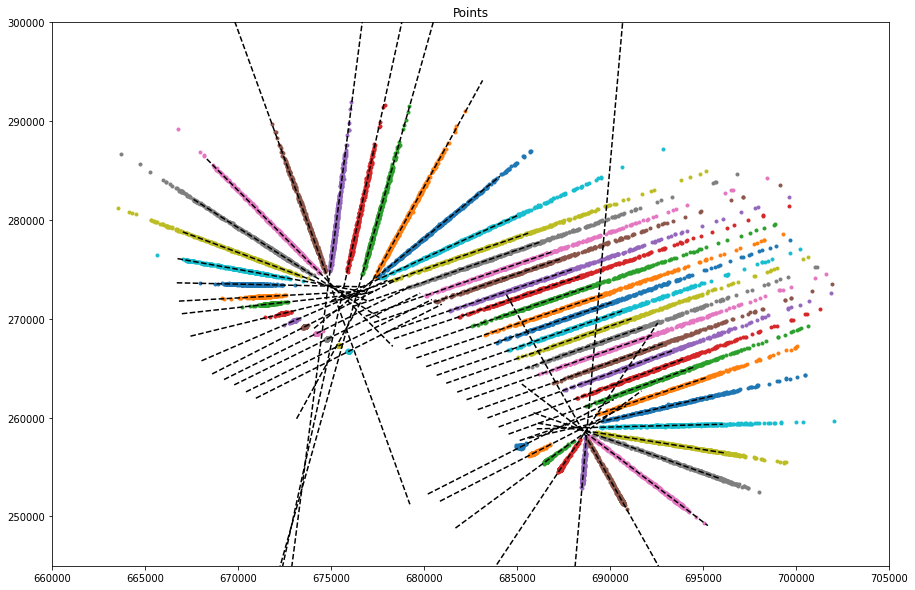

<IPython.core.display.Javascript object>

In [75]:
features = ["x", "y"]
X = np.stack(list(f.data[features].values.ravel() for f in t_GA_resampled))

plt.figure(figsize=(15, 10))

plt.subplot(111)
for i in range(nb_points):
    plt.scatter(X[:, ::2][:, i].T, X[:, 1::2][:, i].T, marker=".")
plt.title("Points")

for ele in perpendiculars:
    y1 = ele[0] * (ele[2] - 5000) + ele[1]
    y2 = ele[0] * (ele[2] + 5000) + ele[1]

    plt.plot(
        [(ele[2] - 5000), (ele[2] + 5000)], [y1, y2], color="black", linestyle="--",
    )

plt.xlim((660000, 705000))
plt.ylim((245000, 300000))
plt.show()

In [76]:
import altair as alt

alt.data_transformers.disable_max_rows()

trajectory = []
for i in range(X.shape[0]):
    trajectory.append(i * np.ones(nb_points))
trajectory = np.array(trajectory).flatten()

point = np.array([range(0, nb_points),] * X.shape[0]).flatten()
test = pd.DataFrame(X[:, ::2].flatten(), columns=["X"])
test["Y"] = X[:, 1::2].flatten()
test["point"] = list(map(str, point))
test["tooltip"] = trajectory

alt.Chart(test).mark_point().encode(
    alt.X("X", scale=alt.Scale(domain=[660000, 705000])),
    alt.Y("Y", scale=alt.Scale(domain=[250000, 300000])),
    alt.Tooltip("tooltip"),
    alt.Color("point"),
).properties(height=600, width=800).interactive()

alt.Chart(...)

<IPython.core.display.Javascript object>